In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip3 install python-louvain

In [ ]:
import itertools, ast, re, pickle, datetime
import pandas as pd
import numpy as np
import copy as cp
from tqdm import tqdm
import networkx as nx
from collections import Counter
from scipy.spatial import distance
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import community.community_louvain as community_louvain

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
all_tweets_df = pd.read_csv('/content/drive/MyDrive/Knowledge Graphs 2022/data/all_tweets.csv')
all_tweets_df['raw_cleaned_text'] = all_tweets_df['raw_cleaned_text'].fillna('')
all_tweets_df['raw_cleaned_text'] = all_tweets_df['raw_cleaned_text'].apply(lambda x: x.lower())
all_tweets_df['cleaned_text'] = all_tweets_df['cleaned_text'].apply(lambda x: ast.literal_eval(x))
all_tweets_df['cleaned_text_str'] = all_tweets_df['cleaned_text'].apply(lambda x: ' '.join(x))
all_tweets_df

id  \
0       1420959115879145474   
1       1420589578541428739   
2       1420533067400105985   
3       1420373718828679174   
4       1420373378653773829   
...                     ...   
923380  1397974274367963136   
923381  1397972983067693064   
923382  1397972391708475392   
923383  1397813255523995648   
923384  1397797047517028353   

                                                     text  \
0       https://t.co/3bM9PoSxS6 #acoustic #orchestra #...   
1       @DekeSlade Hey Rj!  A link to my youtube chann...   
2                    @kraftoki @MinxMore How do you know?   
3       @MinxMore Also, consider that "immune for only...   
4                     @MinxMore It's like chicken pox....   
...                                                   ...   
923380    @Baklava_in_CA @jordanbpeterson I got my pound.   
923381  @nypost He tries to turn his hotel rooms into ...   
923382  @Baklava_in_CA @jordanbpeterson I've realized ...   
923383  So, what do you think the long term side effec...   
923384     @1st_infantry Bye Bob. https://t.co/Fmq6YOsAJq   

                                  time              user_id user_screen_name  \
0       Fri Jul 30 04:07:08 +0000 2021  1404563992907976706         teknoaxe   
1       Thu Jul 29 03:38:43 +0000 2021  1404563992907976706         teknoaxe   
2       Wed Jul 28 23:54:10 +0000 2021  1404563992907976706         teknoaxe   
3       Wed Jul 28 13:20:58 +0000 2021  1404563992907976706         teknoaxe   
4       Wed Jul 28 13:19:37 +0000 2021  1404563992907976706         teknoaxe   
...                                ...                  ...              ...   
923380  Thu May 27 17:53:34 +0000 2021            218741203     mml111mml111   
923381  Thu May 27 17:48:26 +0000 2021            218741203     mml111mml111   
923382  Thu May 27 17:46:05 +0000 2021            218741203     mml111mml111   
923383  Thu May 27 07:13:44 +0000 2021            218741203     mml111mml111   
923384  Thu May 27 06:09:20 +0000 2021            218741203     mml111mml111   

                                             cleaned_text  emotion  topic  \
0                                                      []     fear      0   
1       [youtube, channel, video, music, feature, good...      joy     -1   
2                                                  [know]     fear     83   
3       [also, consider, immune, month, come, journali...     fear      1   
4                                               [chicken]     fear     -1   
...                                                   ...      ...    ...   
923380                                            [pound]      joy     -1   
923381                       [turn, hotel, room, vermont]     fear     -1   
923382  [realize, never, debt, alone, interest, centra...  sadness     -1   
923383                  [think, long, term, side, effect]     fear     -1   
923384                                                 []      joy     -1   

        topic_probability                                   raw_cleaned_text  \
0                1.000000                                                      
1                0.000000  hey rj!  a link to my youtube channel or the v...   
2                1.000000                                   how do you know?   
3                0.764179  also, consider that immune for only a few mont...   
4                0.000000                           its like chicken pox....   
...                   ...                                                ...   
923380           1.000000                                    i got my pound.   
923381           0.271978     he tries to turn his hotel rooms into vermont?   
923382           0.000000  ive realized we are never going to pay that de...   
923383           0.000000  so, what do you think the long term side effec...   
923384           0.000000                                           bye bob.   

                                         cleaned_text_str  \
0          

In [ ]:
topic_df = pd.read_csv('/content/drive/MyDrive/Knowledge Graphs 2022/topic modeling/topic_modeling.csv', index_col=0)
topic_df['keyword'] = topic_df['keyword'].apply(lambda x: ast.literal_eval(x))
keywords_list = list(set([word for words in topic_df['keyword'].tolist() for word in words if word != '']))

In [ ]:
# download stopwords list from nltk library
stop_words_en = stopwords.words('english')
stop_words_spa = stopwords.words('spanish')
# manually extend stopwards list
stop_words_en.extend(["i'm", "\n", "amp", "it's", "it’s", "im", "via", "like", "day", 
                  "time", "go", "got", "get", "one", "lol", "y'all", "y’all", "gonna", "fuck", 
                  "shit", "pls", "plz", "tbh", "rn", "tbt", "ngl", "idc", "idk", "imy", 
                    "i'll", "i've", "let's", "jk", "cuz", "fucking", "fuckin" "wow", "that's", 
                   "dawg", "drop", "pin", "i'd", "lmao", "wtf", "link", "bio", 
                   "youre", "hahaha", "fcking", "today", "followers", "yesssss", "yeah",
                   "eat", "ever", "okay", "morning", "liked", "yes", "haha", "yesss", "thank", "yea", "unfollowers", 
                   "wow", "done", "follow", "unfollow", "dont", "lmfao", "lets", "thanks", "hahaha", "hahahahaha", "sure", "goodbye",
                   "bro", "hehe", "yep", "followed", "follower", "sir", "ids", "sir", "unfollower", "unfollowed", "woohoo", "sayin", "hehehe", "omg"])

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

WORDSET = set()
lemmatizer = WordNetLemmatizer() 
pos_tag = nltk.pos_tag(keywords_list)
wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), pos_tag)

filtered_keywords_list = []

for word, tag in wordnet_tagged:
  if (tag == wordnet.NOUN):
    if (word not in stop_words_en) and (word not in stop_words_spa) and (len(word) > 3):
      lword = lemmatizer.lemmatize(word, pos=tag)
      WORDSET.add(lword)
        

filtered_keywords_list = list(WORDSET)
print(len(filtered_keywords_list))

with open('/content/drive/MyDrive/Knowledge Graphs 2022/semantic network/keywords.list', 'w') as f:
  for keyword in sorted(filtered_keywords_list):
    f.write(f"{keyword}\n")

741


In [ ]:
FOLDER_PATH="/content/drive/MyDrive/Knowledge Graphs 2022/"

In [ ]:
all_tweets_df['raw_cleaned_text'] = all_tweets_df['raw_cleaned_text'].apply(lambda x: x.lower())

In [ ]:
corpus = all_tweets_df['cleaned_text_str'].tolist()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(len(vectorizer.get_feature_names_out()))
print(X.shape)

286306
(923385, 286306)


In [ ]:
n_words = X.shape[1]
words_list = vectorizer.get_feature_names_out()
keywords_indices = [i for i in range(n_words) if words_list[i] in filtered_keywords_list]
print(len(words_list[keywords_indices]))

709


In [ ]:
filtered_X = X[:, keywords_indices]
adj_matrix = filtered_X.T @ filtered_X
adj_matrix.setdiag(0)
adj_matrix

<709x709 sparse matrix of type '<class 'numpy.float64'>'
	with 189583 stored elements in Compressed Sparse Column format>

In [ ]:
row_indices, col_indicexs = adj_matrix.nonzero()
len(row_indices)
adj_matrix.sum() - adj_matrix.toarray().sum()

2.9103830456733704e-11

In [ ]:
adj_df = pd.DataFrame(adj_matrix.toarray(), index=words_list[keywords_indices], columns=words_list[keywords_indices])
adj_df

abortion     abuse  accident    action    advice     alarm  \
abortion  0.000000  0.311841  0.000000  0.421734  0.252615  0.000000   
abuse     0.311841  0.000000  0.052005  0.686884  0.078554  0.000000   
accident  0.000000  0.052005  0.000000  0.132346  0.000000  0.000000   
action    0.421734  0.686884  0.132346  0.000000  0.157962  0.056141   
advice    0.252615  0.078554  0.000000  0.157962  0.000000  0.000000   
...            ...       ...       ...       ...       ...       ...   
yasss     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
year      1.679587  3.022372  0.903488  2.980012  1.046220  0.483788   
yikes     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
youtube   0.059324  0.500751  0.000000  0.331160  0.091472  0.104682   
zinc      0.000000  0.000000  0.000000  0.099194  0.000000  0.000000   

           alberta     album     alice  alinsky  ...      world  wowjust  \
abortion  0.000000  0.000000  0.000000      0.0  ...   1.258713      0.0   
abuse     0.000000  0.000000  0.157521      0.0  ...   1.196598      0.0   
accident  0.000000  0.000000  0.000000      0.0  ...   0.374481      0.0   
action    0.000000  0.000000  0.000000      0.0  ...   2.041435      0.0   
advice    0.000000  0.000000  0.000000      0.0  ...   0.363040      0.0   
...            ...       ...       ...      ...  ...        ...      ...   
yasss     0.000000  0.000000  0.000000      0.0  ...   0.000000      0.0   
year      0.135533  2.391332  0.287001      0.0  ...  13.327905      0.0   
yikes     0.000000  0.000000  0.000000      0.0  ...   0.317546      0.0   
youtube   0.000000  0.168143  0.000000      0.0  ...   2.220988      0.0   
zinc      0.000000  0.000000  0.000000      0.0  ...   0.059220      0.0   

             wuhan  yang    yankee  yasss      year     yikes   youtube  \
abortion  0.000000   0.0  0.000000    0.0  1.679587  0.000000  0.059324   
abuse     0.055646   0.0  0.106026    0.0  3.022372  0.000000  0.500751   
accident  0.137630   0.0  0.000000    0.0  0.903488  0.000000  0.000000   
action    0.035459   0.0  0.000000    0.0  2.980012  0.000000  0.331160   
advice    0.000000   0.0  0.000000    0.0  1.046220  0.000000  0.091472   
...            ...   ...       ...    ...       ...       ...       ...   
yasss     0.000000   0.0  0.000000    0.0  0.000000  0.000000  0.000000   
year      0.920259   0.0  0.198557    0.0  0.000000  0.497298  1.591450   
yikes     0.000000   0.0  0.000000    0.0  0.497298  0.000000  0.000000   
youtube   0.000000   0.0  0.041047    0.0  1.591450  0.000000  0.000000   
zinc      0.000000   0.0  0.000000    0.0  0.156171  0.000000  0.057122   

              zinc  
abortion  0.000000  
abuse     0.000000  
accident  0.000000  
action    0.099194  
advice    0.000000  
...            ...  
yasss     0.000000  
year      0.156171  
yikes     0.000000  
youtube   0.057122  
zinc      0.000000  

[709 rows x 709 columns]

In [ ]:
G = nx.Graph()
G.add_nodes_from(adj_df.index.values)
n_words = len(adj_df.index.values)
for i in tqdm(range(n_words), total=n_words):
  for j in range(i+1, n_words):
    if adj_df.iloc[i, j] > 0:
      G.add_weighted_edges_from([(adj_df.index.values[i], adj_df.index.values[j], adj_df.iloc[i, j])])

nx.info(G)

100%|██████████| 709/709 [00:14<00:00, 48.95it/s] 


'Graph with 709 nodes and 94437 edges'

In [ ]:
!git clone https://github.com/DerwenAI/disparity_filter
import sys
sys.path.append('/content/disparity_filter')
import disparity

Cloning into 'disparity_filter'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 71 (delta 2), reused 6 (delta 1), pack-reused 58
Unpacking objects: 100% (71/71), done.


In [ ]:
min_degree=2
disparity.describe_graph(G, min_degree)
alpha_meansures = disparity.disparity_filter(G)


graph: 709 nodes 94437 edges



In [ ]:
alpha_measures_file = "/content/drive/MyDrive/Knowledge Graphs 2022/semantic network/simple_alpha_measures.npy"
with open(alpha_measures_file, 'wb') as f:
  np.save(f, np.array(alpha_meansures))

with open(alpha_measures_file, 'rb') as f:
  alpha_measures = np.load(alpha_measures_file)

alpha_measures

array([0.56764379, 0.46484685, 0.63214424, ..., 0.86198324, 0.6755628 ,
       0.86653477])

In [ ]:
quantiles, num_quant = disparity.calc_alpha_ptile(alpha_measures)
min_alpha_ptile=0.5
alpha_cutoff = quantiles[round(num_quant * min_alpha_ptile)]
print("\nfilter: percentile {:0.2f}, min alpha {:0.4f}, min degree {}".format(
            min_alpha_ptile, alpha_cutoff, min_degree
            ))

	ptile	alpha
	0.00	0.0000
	0.10	0.1362
	0.20	0.3290
	0.30	0.4798
	0.40	0.5993
	0.50	0.6950
	0.60	0.7753
	0.70	0.8416
	0.80	0.9034
	0.90	0.9962

filter: percentile 0.50, min alpha 0.6950, min degree 2


In [ ]:
G_copy = G.copy()
disparity.cut_graph(G_copy, min_alpha_ptile, min_degree)
disparity.save_graph(G_copy, "/content/drive/MyDrive/Knowledge Graphs 2022/semantic network/simple_disparity_filter_graph.json")
disparity.describe_graph(G_copy, min_degree)


graph: 686 nodes 49015 edges



In [ ]:
G_copy.get_edge_data('uncle', 'welcome')

{'alpha': 0.9240821779847936,
 'alpha_ptile': 0.9390417173083178,
 'norm_weight': 0.00014354292233265727,
 'weight': 0.11933014848477129}

In [ ]:
partitions = community_louvain.best_partition(G_copy)

{'abortion': 0,
 'abuse': 0,
 'accident': 3,
 'action': 0,
 'advice': 2,
 'alarm': 2,
 'alberta': 3,
 'album': 3,
 'alice': 3,
 'alinsky': 1,
 'ammo': 0,
 'anarchist': 2,
 'angel': 2,
 'animal': 0,
 'anime': 3,
 'anon': 3,
 'antifa': 0,
 'apple': 2,
 'april': 2,
 'argument': 2,
 'arizona': 2,
 'arkansas': 2,
 'article': 0,
 'asshole': 0,
 'athlete': 2,
 'audience': 3,
 'audit': 0,
 'august': 2,
 'aussie': 2,
 'avenatti': 3,
 'babbitt': 2,
 'baby': 0,
 'badass': 1,
 'ball': 0,
 'ballot': 0,
 'barack': 2,
 'barrett': 2,
 'baseball': 2,
 'basement': 2,
 'bass': 1,
 'batman': 3,
 'bday': 3,
 'beast': 2,
 'beauty': 2,
 'beer': 2,
 'betcha': 0,
 'beto': 1,
 'bias': 2,
 'biden': 2,
 'bidens': 0,
 'bigotry': 2,
 'bill': 2,
 'binance': 1,
 'bingo': 2,
 'birthday': 2,
 'bitch': 0,
 'bitter': 2,
 'bittrex': 0,
 'blame': 0,
 'bless': 0,
 'blog': 3,
 'blood': 2,
 'blue': 0,
 'boat': 3,
 'boom': 2,
 'border': 0,
 'boris': 2,
 'bowl': 1,
 'boycott': 2,
 'bracelet': 0,
 'brave': 2,
 'breath': 2,
 'bre

In [ ]:
[k for k, v in partitions.items() if v == 3]

['accident',
 'alberta',
 'album',
 'alice',
 'anime',
 'anon',
 'audience',
 'avenatti',
 'batman',
 'bday',
 'blog',
 'boat',
 'carlsons',
 'charlie',
 'click',
 'club',
 'coach',
 'cocaine',
 'coffee',
 'cola',
 'condolence',
 'consent',
 'constituent',
 'cookie',
 'cooper',
 'crack',
 'creature',
 'creep',
 'creepy',
 'crook',
 'crow',
 'crowd',
 'cummings',
 'defund',
 'delta',
 'delusion',
 'demon',
 'depopulation',
 'design',
 'devil',
 'diana',
 'dictatorship',
 'dirt',
 'diwas',
 'documentary',
 'doge',
 'dominion',
 'dozen',
 'drama',
 'drinking',
 'drip',
 'drought',
 'drunk',
 'economics',
 'episode',
 'eugenics',
 'family',
 'farrakhan',
 'faucis',
 'fentanyl',
 'filibuster',
 'footprint',
 'forget',
 'foundation',
 'fridge',
 'friend',
 'gaslighting',
 'gate',
 'giannis',
 'giant',
 'glass',
 'goat',
 'gosh',
 'grandma',
 'gretsch',
 'grill',
 'guinea',
 'guitar',
 'haiti',
 'haitian',
 'hamas',
 'happiness',
 'heel',
 'hello',
 'henry',
 'hipaa',
 'hippa',
 'hunter',
 'h

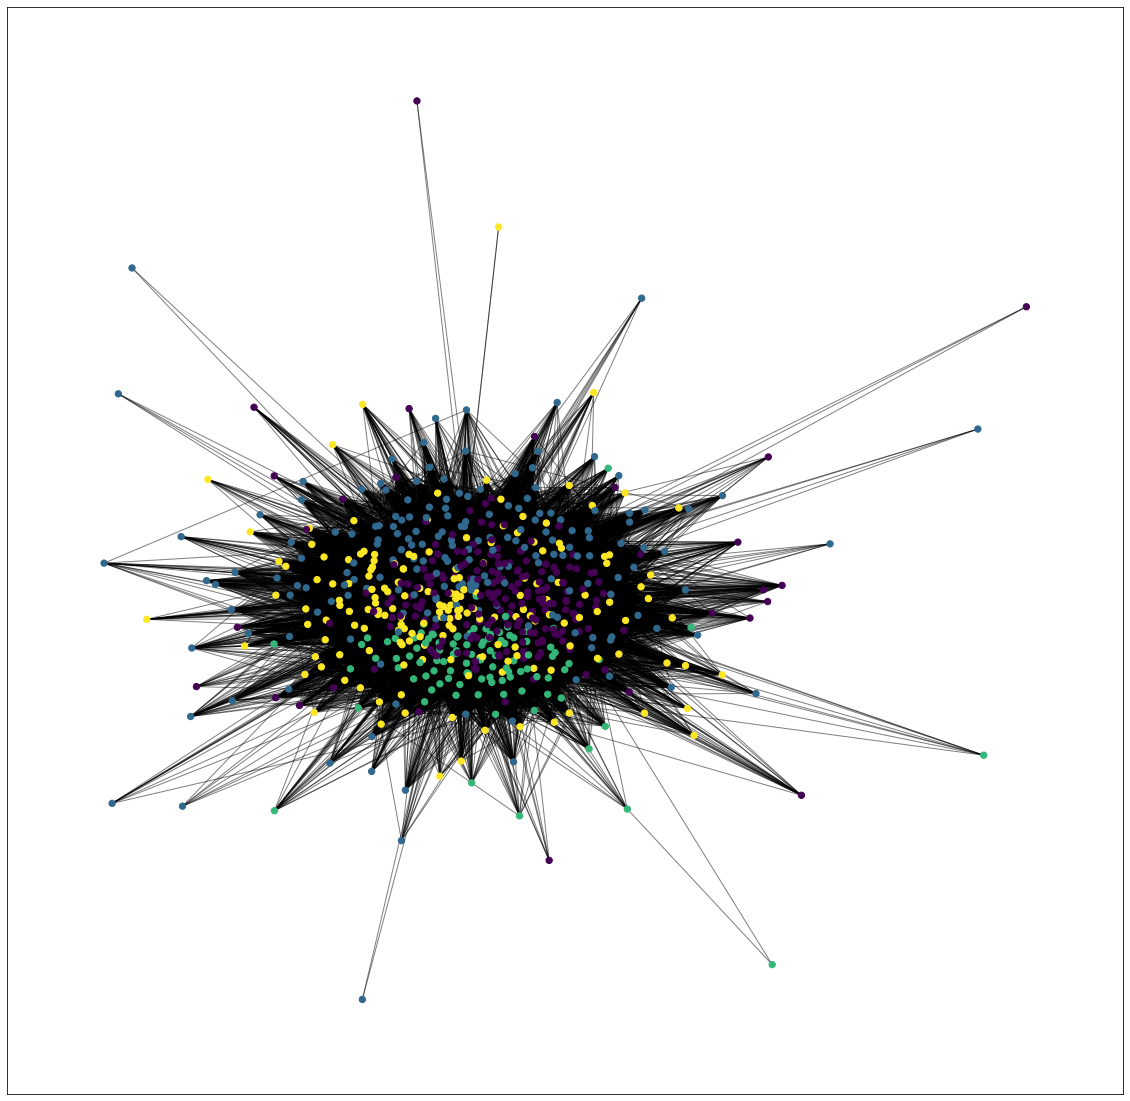

In [ ]:
# draw the graph
plt.figure(figsize=(20,20))
pos = nx.spring_layout(G_copy)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partitions.values()) + 1)
nx.draw_networkx_nodes(G_copy, pos, partitions.keys(), node_size=40,
                       cmap=cmap, node_color=list(partitions.values()))
nx.draw_networkx_edges(G_copy, pos, alpha=0.5)
plt.show()

In [ ]:
nx.info(G)

list(nx.connected_components(G)) #1715 is disjoint from other nodes

[{'abortion',
  'abuse',
  'accident',
  'action',
  'advice',
  'alarm',
  'alberta',
  'album',
  'alice',
  'alinsky',
  'ammo',
  'anarchist',
  'angel',
  'animal',
  'anime',
  'anon',
  'antifa',
  'apple',
  'april',
  'argument',
  'arizona',
  'arkansas',
  'article',
  'asshole',
  'athlete',
  'audience',
  'audit',
  'august',
  'aussie',
  'avenatti',
  'babbitt',
  'baby',
  'badass',
  'ball',
  'ballot',
  'barack',
  'barrett',
  'baseball',
  'basement',
  'bass',
  'batman',
  'bday',
  'beast',
  'beauty',
  'beer',
  'betcha',
  'beto',
  'bias',
  'biden',
  'bidens',
  'bigotry',
  'bill',
  'binance',
  'bingo',
  'birthday',
  'bitch',
  'bitter',
  'bittrex',
  'blackmailedbig',
  'blame',
  'bless',
  'blog',
  'blood',
  'blue',
  'boat',
  'boom',
  'border',
  'boris',
  'bowl',
  'boycott',
  'bracelet',
  'brave',
  'breath',
  'brexit',
  'brook',
  'bull',
  'burn',
  'business',
  'cage',
  'canada',
  'canadian',
  'cancel',
  'capitalism',
  'capit

In [ ]:
G_disparity = disparity.load_graph("/content/drive/MyDrive/Knowledge Graphs 2022/semantic network/simple_disparity_filter_graph.json")
nx.info(G_disparity)

disparity_adj_mat = nx.adjacency_matrix(G_disparity).todense()

with open("/content/drive/MyDrive/Knowledge Graphs 2022/semantic network/adj_mat_1.npy", 'wb') as f:
    np.save(f, disparity_adj_mat)

with open("/content/drive/MyDrive/Knowledge Graphs 2022/semantic network/adj_mat_1.npy", 'rb') as f:
    test = np.load(f)

test

array([[0.        , 0.        , 0.        , ..., 0.        , 0.05932417,
        0.        ],
       [0.        , 0.        , 0.05200547, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05200547, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05932417, 0.        , 0.        , ..., 0.        , 0.        ,
        0.05712163],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05712163,
        0.        ]])

## Hashtag Co-occurrence Network

In [ ]:
data_path = '/content/drive/MyDrive/Knowledge Graphs 2022/data/all_tweets.pickle'
with open(data_path, 'rb') as f:
  all_tweets = pickle.load(f)

In [ ]:
id2hashtags = {}
no_hashtags_list = []
for key in tqdm(all_tweets.keys(), total=len(all_tweets.keys())):
  user_tweets = all_tweets[key][0]
  for tweet in user_tweets:
    id = tweet['id']
    try:
      hashtags = [x['text'] for x in tweet['entities']['hashtags']]
      id2hashtags[id] = hashtags
    except:
      no_hashtags_list.append(id)

100%|██████████| 12975/12975 [00:01<00:00, 6749.88it/s]


In [ ]:
hashtag_df = pd.DataFrame({"id": id2hashtags.keys(), "hashtags": id2hashtags.values()})

In [ ]:
all_tweets_w_hashtags = pd.merge(all_tweets_df, hashtag_df)
print(len(all_tweets_w_hashtags[all_tweets_w_hashtags['hashtags'].str.len() > 0]))
all_tweets_w_hashtags.to_csv(FOLDER_PATH+'/data/all_tweets.csv', index=False)
pd.read_csv(FOLDER_PATH+'/data/all_tweets.csv')

105747


id  \
0       1420959115879145474   
1       1420589578541428739   
2       1420533067400105985   
3       1420373718828679174   
4       1420373378653773829   
...                     ...   
923380  1397974274367963136   
923381  1397972983067693064   
923382  1397972391708475392   
923383  1397813255523995648   
923384  1397797047517028353   

                                                     text  \
0       https://t.co/3bM9PoSxS6 #acoustic #orchestra #...   
1       @DekeSlade Hey Rj!  A link to my youtube chann...   
2                    @kraftoki @MinxMore How do you know?   
3       @MinxMore Also, consider that "immune for only...   
4                     @MinxMore It's like chicken pox....   
...                                                   ...   
923380    @Baklava_in_CA @jordanbpeterson I got my pound.   
923381  @nypost He tries to turn his hotel rooms into ...   
923382  @Baklava_in_CA @jordanbpeterson I've realized ...   
923383  So, what do you think the long term side effec...   
923384     @1st_infantry Bye Bob. https://t.co/Fmq6YOsAJq   

                                  time              user_id user_screen_name  \
0       Fri Jul 30 04:07:08 +0000 2021  1404563992907976706         teknoaxe   
1       Thu Jul 29 03:38:43 +0000 2021  1404563992907976706         teknoaxe   
2       Wed Jul 28 23:54:10 +0000 2021  1404563992907976706         teknoaxe   
3       Wed Jul 28 13:20:58 +0000 2021  1404563992907976706         teknoaxe   
4       Wed Jul 28 13:19:37 +0000 2021  1404563992907976706         teknoaxe   
...                                ...                  ...              ...   
923380  Thu May 27 17:53:34 +0000 2021            218741203     mml111mml111   
923381  Thu May 27 17:48:26 +0000 2021            218741203     mml111mml111   
923382  Thu May 27 17:46:05 +0000 2021            218741203     mml111mml111   
923383  Thu May 27 07:13:44 +0000 2021            218741203     mml111mml111   
923384  Thu May 27 06:09:20 +0000 2021            218741203     mml111mml111   

                                             cleaned_text  emotion  topic  \
0                                                      []     fear      0   
1       ['youtube', 'channel', 'video', 'music', 'feat...      joy     -1   
2                                                ['know']     fear     83   
3       ['also', 'consider', 'immune', 'month', 'come'...     fear      1   
4                                             ['chicken']     fear     -1   
...                                                   ...      ...    ...   
923380                                          ['pound']      joy     -1   
923381               ['turn', 'hotel', 'room', 'vermont']     fear     -1   
923382  ['realize', 'never', 'debt', 'alone', 'interes...  sadness     -1   
923383        ['think', 'long', 'term', 'side', 'effect']     fear     -1   
923384                                                 []      joy     -1   

        topic_probability                                   raw_cleaned_text  \
0                1.000000                                                NaN   
1                0.000000  hey rj!  a link to my youtube channel or the v...   
2                1.000000                                   how do you know?   
3                0.764179  also, consider that immune for only a few mont...   
4                0.000000                           its like chicken pox....   
...                   ...                                                ...   
923380           1.000000                                    i got my pound.   
923381           0.271978     he tries to turn his hotel rooms into vermont?   
923382           0.000000  ive realized we are never going to pay that de...   
923383           0.000000  so, what do you think the long term side effec...   
923384           0.000000                                           bye bob.   

                                         cleaned_text_str  \
0          

In [ ]:
# id2hashtags_filtered = {k: v for k, v in id2hashtags.items() if v}
tweets_hashtags_file = FOLDER_PATH+"/semantic network/tweets_hashtags.pickle"
# with open(tweets_hashtags_file, "wb") as f:
#    pickle.dump(id2hashtags_filtered, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(tweets_hashtags_file, "rb") as f:
  id2hashtags_filtered = pickle.load(f)

# print(id2hashtags_filtered == test)
print(len(id2hashtags_filtered.keys()))

105747


In [ ]:
lemmatizer = WordNetLemmatizer()

for id, hashtags in tqdm(id2hashtags_filtered.items(), total=len(id2hashtags_filtered.keys())):
  lemmatized_hashtags = []
  for hashtag in hashtags:
    lemmatized_hashtags.append(lemmatizer.lemmatize(hashtag.lower()))
  id2hashtags_filtered[id] = lemmatized_hashtags

100%|██████████| 105747/105747 [00:02<00:00, 38289.31it/s]


In [ ]:
hashtag_counts = Counter([hashtag for id, hashtags in id2hashtags_filtered.items() for hashtag in hashtags])
filtered_hashtag_words = [hashtag for hashtag, count in hashtag_counts.items() if count > 100]
id2hashtags_filtered_again = {k: v for k, v in id2hashtags_filtered.items() if bool(set(filtered_hashtag_words) & set(v))}
print(len(filtered_hashtag_words))
print(len(id2hashtags_filtered_again.keys()))

314
40337


In [ ]:
n_hashtags = len(filtered_hashtag_words)
n_filterd_users = len(id2hashtags_filtered_again.keys())

In [ ]:
hashtag_adj_matrix = np.zeros((n_hashtags, n_hashtags))
for id, hashtags in tqdm(id2hashtags_filtered_again.items(), total=n_filterd_users):
  for i in range(n_hashtags):
    for j in range(n_hashtags):
      if (filtered_hashtag_words[i] in hashtags) and (filtered_hashtag_words[j] in hashtags):
        hashtag_adj_matrix[i][j] += 1
        hashtag_adj_matrix[j][i] += 1

hashtag_adj_matrix /= 2

100%|██████████| 40337/40337 [11:08<00:00, 60.34it/s]


In [ ]:
with open(FOLDER_PATH+"/semantic network/lemmentized_hastag_adj_matrix.npy", "wb") as f:
  np.save(f, hashtag_adj_matrix)

with open(FOLDER_PATH+"/semantic network/lemmentized_hastag_adj_matrix.npy", "rb") as f:
  test = np.load(f)

print(test == hashtag_adj_matrix)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [ ]:
with open(FOLDER_PATH+"/semantic network/lemmentized_hastag_adj_matrix.npy", "rb") as f:
  hashtag_adj_matrix = np.load(f)

In [ ]:
hashtag_df = pd.DataFrame(hashtag_adj_matrix)
jaccard_matrix = 1 - distance.cdist(hashtag_adj_matrix, hashtag_adj_matrix, 'jaccard')
pd.DataFrame(jaccard_matrix)

0         1         2         3         4         5         6    \
0    1.000000  0.032258  0.018018  0.026316  0.035714  0.025641  0.020000   
1    0.032258  1.000000  0.127119  0.060150  0.091549  0.070707  0.087838   
2    0.018018  0.127119  1.000000  0.070866  0.026490  0.071429  0.041667   
3    0.026316  0.060150  0.070866  1.000000  0.032051  0.009174  0.029762   
4    0.035714  0.091549  0.026490  0.032051  1.000000  0.015504  0.037736   
..        ...       ...       ...       ...       ...       ...       ...   
309  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
310  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
311  0.000000  0.010638  0.000000  0.000000  0.000000  0.000000  0.000000   
312  0.000000  0.000000  0.000000  0.011628  0.008403  0.000000  0.000000   
313  0.000000  0.008772  0.018868  0.011111  0.007194  0.000000  0.006757   

          7         8         9    ...       304       305       306  \
0    0.017751  0.046512  0.022989  ...  0.013699  0.013333  0.013158   
1    0.077381  0.096774  0.041176  ...  0.029412  0.009804  0.009804   
2    0.054878  0.074380  0.041667  ...  0.000000  0.030928  0.020408   
3    0.073333  0.020134  0.031579  ...  0.037383  0.018692  0.027778   
4    0.055556  0.062500  0.068571  ...  0.007937  0.015748  0.023622   
..        ...       ...       ...  ...       ...       ...       ...   
309  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
310  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
311  0.007092  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
312  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
313  0.021583  0.007874  0.011696  ...  0.013699  0.013333  0.000000   

          307       308  309  310       311       312       313  
0    0.013514  0.012346  0.0  0.0  0.000000  0.000000  0.000000  
1    0.019608  0.008475  0.0  0.0  0.010638  0.000000  0.008772  
2    0.000000  0.009174  0.0  0.0  0.000000  0.000000  0.018868  
3    0.027778  0.061224  0.0  0.0  0.000000  0.011628  0.011111  
4    0.007874  0.022727  0.0  0.0  0.000000  0.008403  0.007194  
..        ...       ...  ...  ...       ...       ...       ...  
309  0.000000  0.000000  1.0  0.0  0.000000  0.000000  0.000000  
310  0.000000  0.000000  0.0  1.0  0.000000  0.000000  0.000000  
311  0.000000  0.019608  0.0  0.0  1.000000  0.000000  0.000000  
312  0.000000  0.000000  0.0  0.0  0.000000  1.000000  0.000000  
313  0.000000  0.012987  0.0  0.0  0.000000  0.000000  1.000000  

[314 rows x 314 columns]

In [ ]:
nodes = []

for i in range(n_hashtags):
  for j in range(i+1, n_hashtags):
    if jaccard_matrix[i, j] > 0.1 and jaccard_matrix[i, j] != 1:
      nodes.append([filtered_hashtag_words[i], filtered_hashtag_words[j], hashtag_adj_matrix[i, i], hashtag_adj_matrix[j, j], jaccard_matrix[i, j]])

len(nodes)

531

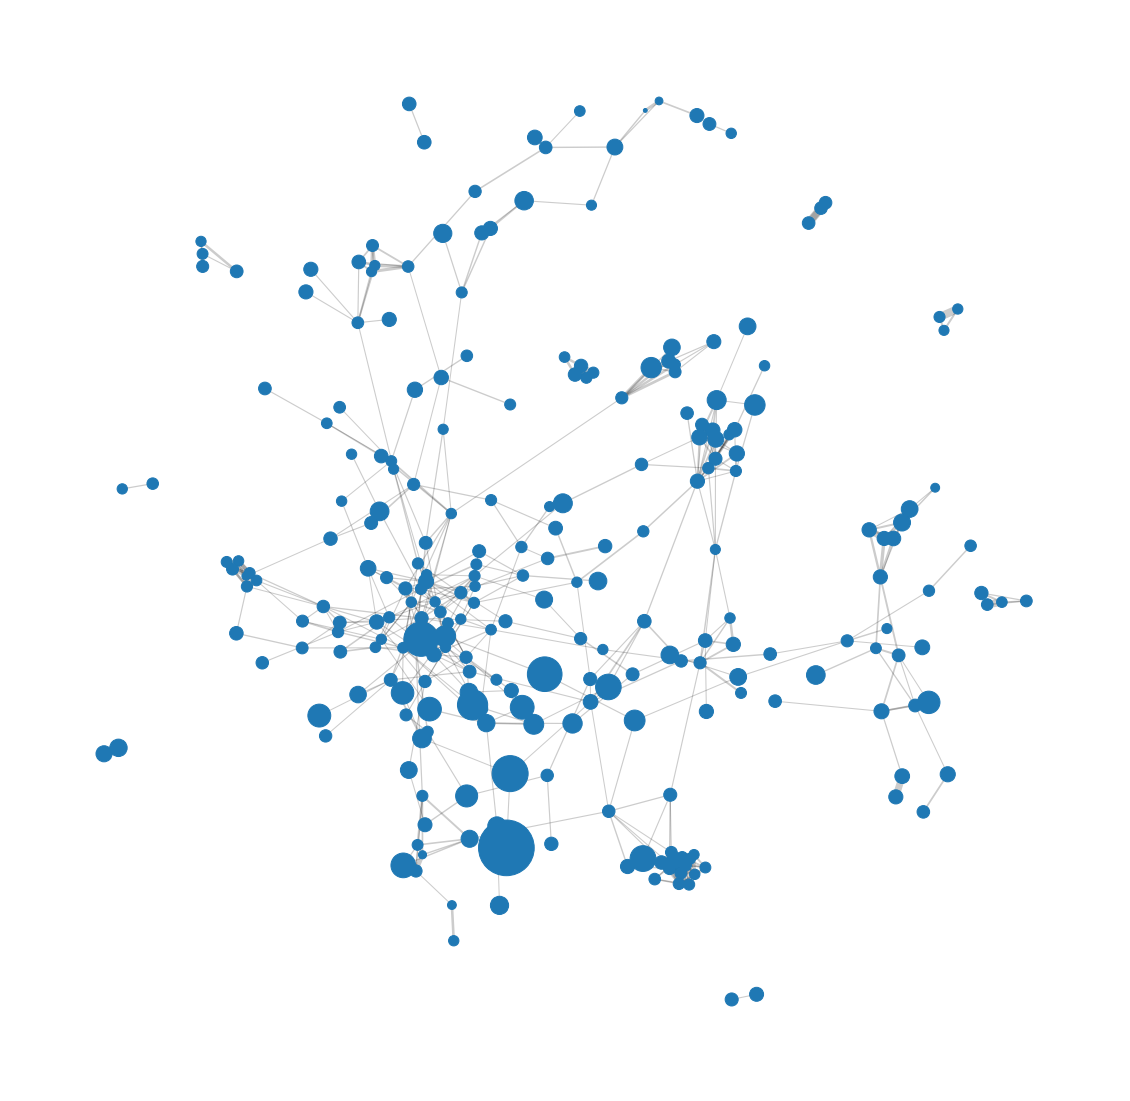

In [ ]:
G = nx.Graph()
G.nodes(data=True)

for pair in nodes:
    node_x, node_y, node_x_cnt, node_y_cnt, jaccard = pair[0], pair[1], pair[2], pair[3], pair[4]
    if not G.has_node(node_x):
        G.add_node(node_x, count=node_x_cnt)
    if not G.has_node(node_y):
        G.add_node(node_y, count=node_y_cnt)
    if not G.has_edge(node_x, node_y):
        G.add_edge(node_x, node_y, weight=jaccard)
        
plt.figure(figsize=(20,20))
pos = nx.fruchterman_reingold_layout(G)

node_size = [d['count'] for (n,d) in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, alpha=1.0, node_size=node_size)
# nx.draw_networkx_labels(G, pos)

edge_width = [d['weight']*10 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='black', width=edge_width)

plt.axis('off')
plt.show()


In [ ]:
plt.figure(figsize=(20,20))
# compute the best partition
partition = community_louvain.best_partition(G)
node_size = [d['count'] for (n,d) in G.nodes(data=True)]
# draw the graph
pos = nx.fruchterman_reingold_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=node_size,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
communities = list(set(partition.values()))
comm2hashtags = {id: [] for id in communities}
for hashtag, id in partition.items():
  comm2hashtags[id].append(hashtag)

comm2closeness = {id: [] for id in communities}
for id, hashtags in tqdm(comm2hashtags.items(), total=len(comm2hashtags.items())):
  n = len(hashtags)
  for hashtag in hashtags:
    comm2closeness[id].append((hashtag, ((n-1)/(sum([nx.shortest_path_length(G, source=hashtag, target=other) for other in hashtags])))))

100%|██████████| 22/22 [00:00<00:00, 343.26it/s]


In [ ]:
labels = {}
max_len_comm = 0
for id, closeness in comm2closeness.items():
  comm2closeness[id] = sorted(closeness, key=lambda x: x[1], reverse=True)
  hub = comm2closeness[id][0][0]
  labels[hub] = f"#{hub}"
  if max_len_comm < len(closeness): max_len_comm = len(closeness)

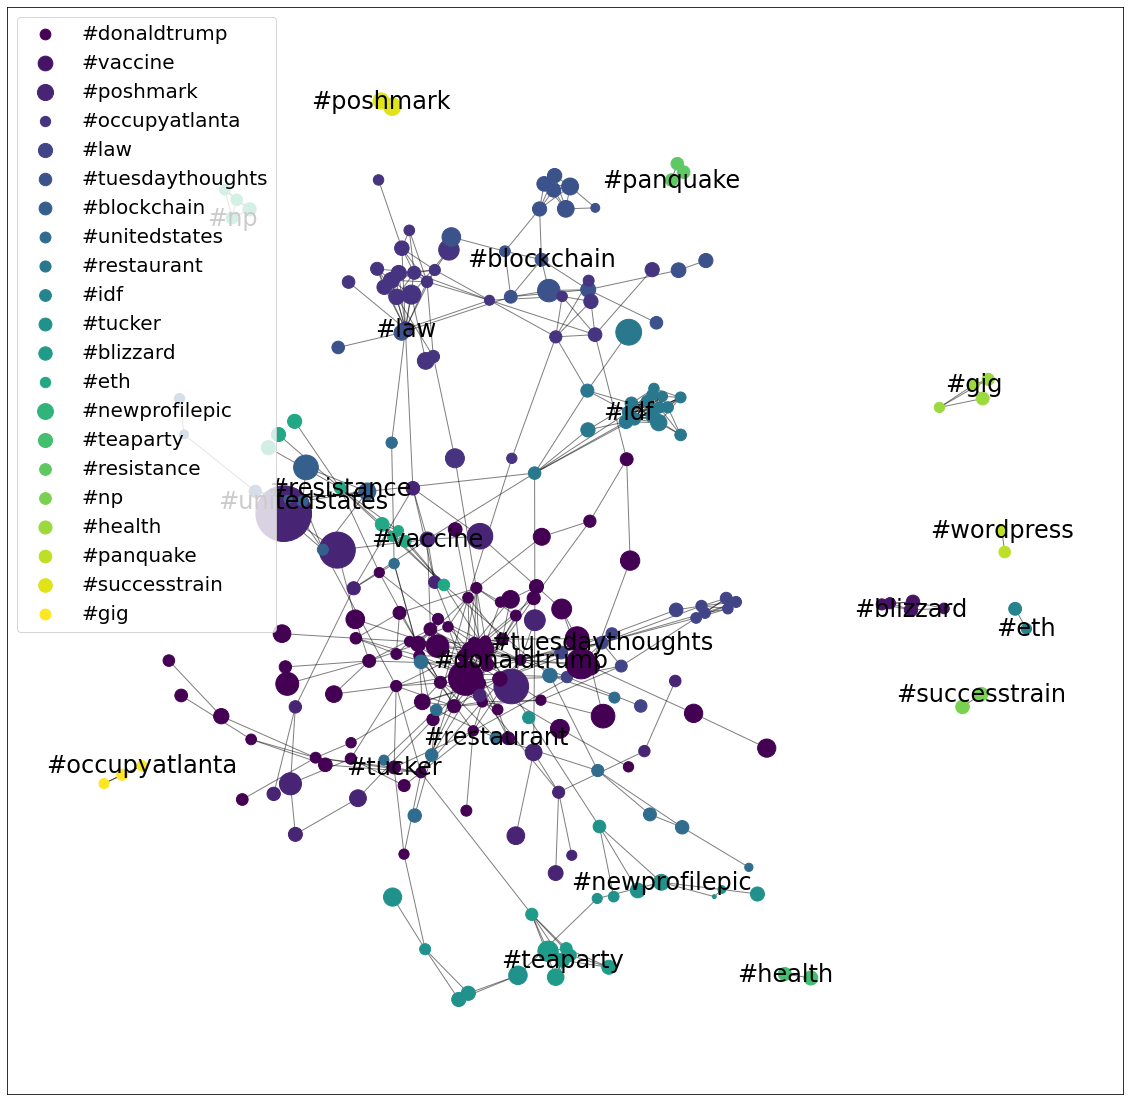

In [ ]:
plt.figure(figsize=(20,20))
# compute the best partition
partition = community_louvain.best_partition(G)
node_size = [d['count'] for (n,d) in G.nodes(data=True)]
# draw the graph
pos = nx.fruchterman_reingold_layout(G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=node_size,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=24)

comm_label_size = [G.nodes(data=True)[label]['count'] for label in labels.keys()]
for v in set(list(partition.values())):
    plt.scatter([],[], c=[cmap(v)], label=list(labels.values())[v], s=comm_label_size[v])


plt.legend(fontsize=20)
plt.show()

In [ ]:
betw_central_list = sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)
betw_central_dict = {k: v for k, v in betw_central_list}
comm2betweenness = {}
for comm, hashtags in comm2closeness.items():
  comm2betweenness[comm] = []
  for hashtag, _ in hashtags:
    comm2betweenness[comm].append((hashtag, betw_central_dict[hashtag]))


betw_central_labels = {}
for id, betweenness in comm2betweenness.items():
  comm2betweenness[id] = sorted(betweenness, key=lambda x: x[1], reverse=True)
  hub = comm2betweenness[id][0][0]
  betw_central_labels[hub] = f"#{hub}"

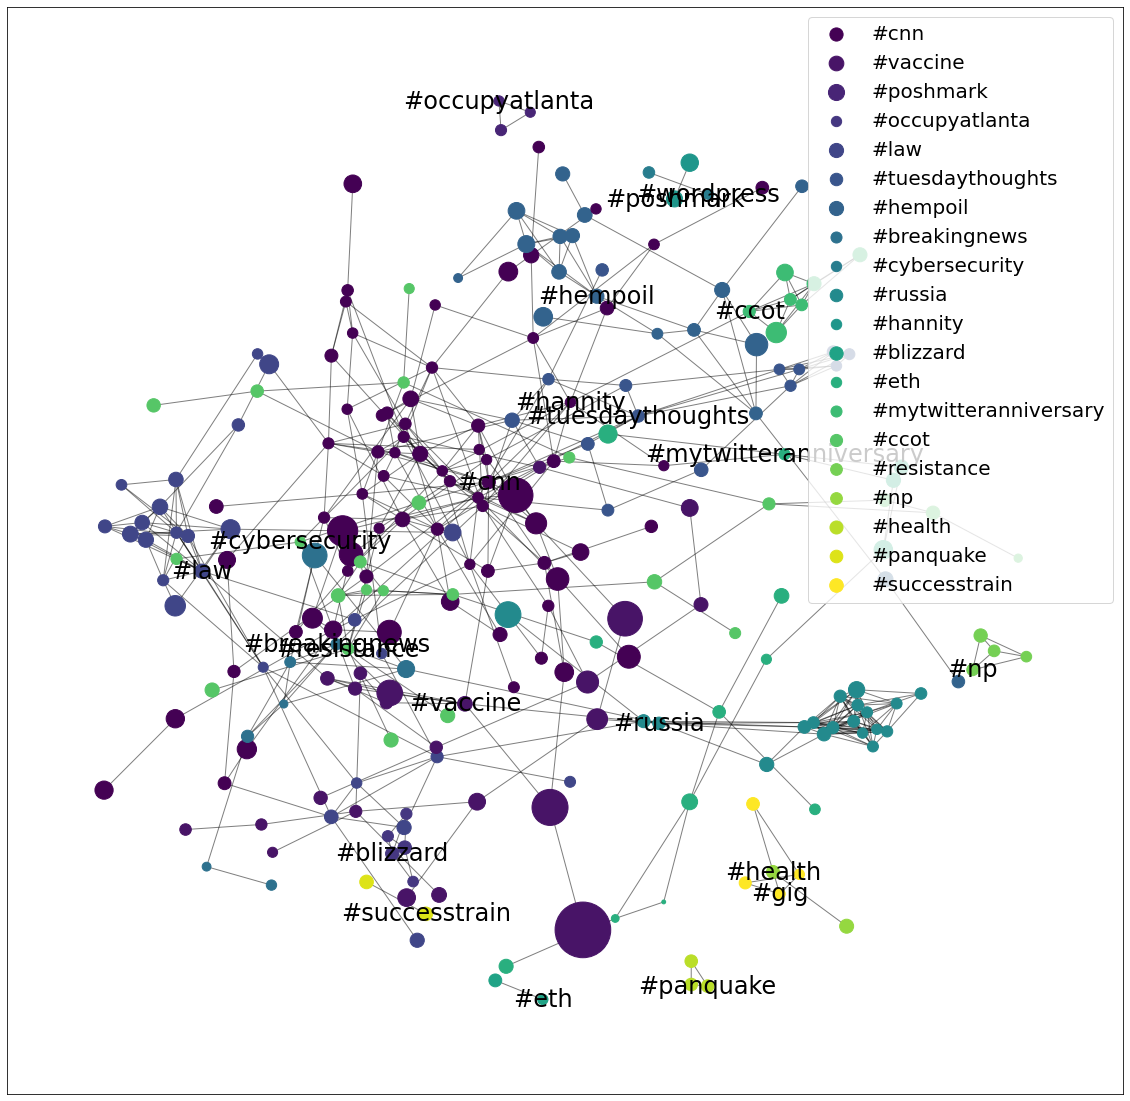

In [ ]:
plt.figure(figsize=(20,20))
# compute the best partition
partition = community_louvain.best_partition(G)
node_size = [d['count'] for (n,d) in G.nodes(data=True)]
# draw the graph
pos = nx.spring_layout(G, k=0.1)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=node_size,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels=betw_central_labels, font_size=24)

comm_label_size = [G.nodes(data=True)[label]['count'] for label in betw_central_labels.keys()]
for v in set(list(partition.values())):
    plt.scatter([],[], c=[cmap(v)], label=list(betw_central_labels.values())[v], s=comm_label_size[v])


plt.legend(fontsize=20)
plt.show()

In [ ]:
comm2closeness_copy = comm2closeness.copy()
for id, closeness in comm2closeness_copy.items():
  while len(closeness) < max_len_comm:
    comm2closeness_copy[id].append(('', 0))
  comm2hashtags[id] = [hashtag for hashtag, closeness in comm2closeness_copy[id]]

hashtag_community_df = pd.DataFrame(comm2hashtags)
# hashtag_community_df.to_csv(FOLDER_PATH+"/semantic network/hashtags_community.csv", header=False, index=False)
hashtag_community_df

0            1             2              3   \
0                     donaldtrump      vaccine      poshmark  occupyatlanta   
1                             cnn      economy  shopmycloset            ows   
2              trump2020landslide       travel                     reoccupy   
3                      republican           uk                                
4                blacklivesmatter  coronavirus                                
5                          antifa     business                                
6                         godwins        china                                
7                    election2020     pakistan                                
8                      freespeech        trump                                
9                   patriotsunite      patriot                                
10                      hypocrite  humanrights                                
11                       joebiden       corona                                
12                        votered   technology                                
13                          biden      covid19                                
14                     voterfraud        covid                                
15                        foxnews    australia                                
16  democratsaredestroyingamerica        qanon                                
17                     censorship     politics                                
18                         racist       canada                                
19                     trumptrain                                             
20                    backtheblue                                             
21                        liberty                                             
22                       american                                             
23                            msm                                             
24                  draintheswamp                                             
25    liberalismisamentaldisorder                                             
26                             2a                                             
27                            ccp                                             
28                        treason                                             
29                   constitution                                             
30                         wakeup                                             
31                       democrat                                             
32                       fakenews                                             
33                        liberal                                             
34                  electionfraud                                             
35                            blm                                             
36                   patriotparty                                             
37                      trump2020                                             
38                          potus                                             
39                        traitor                                             
40                      deepstate                                             
41                        america                                             
42                   stopthesteai                                             
43                   stopthesteal                                             
44                    watercrisis                                             
45                     leadership                                             
46                         qanons                                             
47                        cdnpoli                                             
48                 greatawakening                                             
49                godblessamerica                                             
50

In [ ]:
def get_related_tweets(community_id, hashtag_community_df):
  comm_tweet_id_list = []
  for id, hashtags in tqdm(id2hashtags_filtered.items(), total=len(id2hashtags_filtered.items())):
    if bool(set(hashtags) & set(hashtag_community_df.iloc[:, community_id].values)):
      comm_tweet_id_list.append(id)
  print()
  print(f"{len(comm_tweet_id_list)} tweets here")
  comm_tweet_df = all_tweets_df[all_tweets_df['id'].isin(comm_tweet_id_list)]
  comm_tweet_df[comm_tweet_df['cleaned_text'].str.len() > 0]['topic'].hist(bins=200, range=(0, 200))
  topic_counts = sorted(Counter(comm_tweet_df[comm_tweet_df['cleaned_text'].str.len() > 0]['topic']).items(), key=lambda x: x[1], reverse=True)[1:]
  topicId2keywords = {}
  for topic_id, counts in topic_counts:
    topicId2keywords[topic_id] = {'counts': counts, 'keywords': topic_df[topic_df['topic_id'] == topic_id].keyword.tolist()[0]}
  print(sorted(topicId2keywords.items(), key=lambda x: x[1]['counts'], reverse=True)[:10])
  comm_tweet_df.index = pd.to_datetime(comm_tweet_df['time'], infer_datetime_format=True)
  
  comm_tweet_df_copy = comm_tweet_df.copy()
  comm_tweet_df_copy['dummy'] = [1]*len(comm_tweet_df_copy)

  fig, axs = plt.subplots(figsize=(12, 4))
  comm_tweet_df_copy.loc['2020-01-01':'2020-12-31'].groupby(comm_tweet_df_copy.loc['2020-01-01':'2020-12-31'].index.month)['dummy'].sum().plot(kind = 'bar', rot=0, ax=axs)

  plt.xlabel("time")
  plt.ylabel("tweet counts")
  return comm_tweet_df

In [ ]:
comm_tweets_df_9 = get_related_tweets(9, hashtag_community_df)

100%|██████████| 105747/105747 [00:06<00:00, 16539.21it/s]


9214 tweets here
[(6, {'counts': 472, 'keywords': ['latest', 'thanks', 'sense', 'common', 'millenial', 'loft', 'consulting', 'hedges', 'godsword', 'aussie']}), (4, {'counts': 261, 'keywords': ['daily', 'latest', 'thanks', 'project', 'coach', 'politics', 'united', 'vets', 'carson', 'shochat']}), (124, {'counts': 207, 'keywords': ['story', 'stories', 'press', 'department', 'top', 'daily', 'latest', 'mostshared', 'thanks', 'briefing']}), (189, {'counts': 159, 'keywords': ['blue', 'parody', 'red', 'chan', 'true', 'states', 'account', 'ronpaulpatriots', 'litmargaretnan', 'jonflombee']}), (106, {'counts': 150, 'keywords': ['coffee', 'mug', 'oz', 'cup', 'gift', 'tea', 'anon', 'coincidence', 'awakening', 'ceramic']}), (1, {'counts': 131, 'keywords': ['vaccine', 'vaccinated', 'vaccines', 'covid', 'vax', 'delta', 'unvaccinated', 'vaccination', 'variant', 'jab']}), (14, {'counts': 126, 'keywords': ['amp', 'guitar', 'teleprompter', 'to', 'of', 'the', 'it', 'our', 'their', 'gretsch']}), (51, {'coun

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


100%|██████████| 105747/105747 [00:06<00:00, 16586.10it/s]


1295 tweets here
[(4, {'counts': 20, 'keywords': ['daily', 'latest', 'thanks', 'project', 'coach', 'politics', 'united', 'vets', 'carson', 'shochat']}), (34, {'counts': 18, 'keywords': ['kabir', 'ji', 'pm', 'rampal', 'june', 'prakat', 'diwas', 'maharaj', 'god', 'sant']}), (6, {'counts': 13, 'keywords': ['latest', 'thanks', 'sense', 'common', 'millenial', 'loft', 'consulting', 'hedges', 'godsword', 'aussie']}), (154, {'counts': 13, 'keywords': ['rally', 'ohio', 'crowd', 'nc', 'trump', 'rallies', 'carolina', 'president', 'sarasota', 'live']}), (9, {'counts': 11, 'keywords': ['conspiracy', 'maga', 'qanon', 'sent', 'hat', 'boom', 'hats', 'dm', 'drop', 'theory']}), (14, {'counts': 10, 'keywords': ['amp', 'guitar', 'teleprompter', 'to', 'of', 'the', 'it', 'our', 'their', 'gretsch']}), (118, {'counts': 10, 'keywords': ['youtube', 'rampal', 'ji', 'sant', 'channel', 'maharaj', 'visit', 'satlok', 'ashram', 'saint']}), (92, {'counts': 10, 'keywords': ['via', 'presents', 'tv', 'moving', 'tb', 'mot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


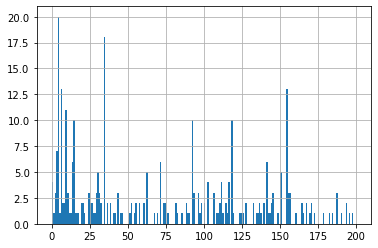

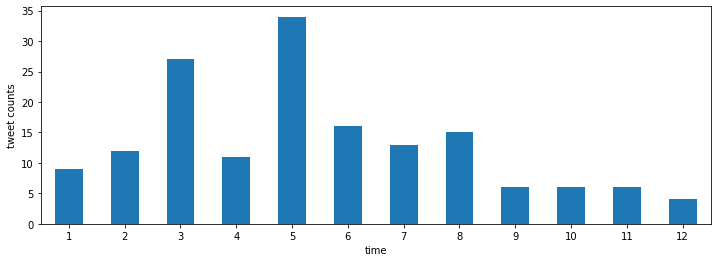

In [ ]:
comm_tweets_df_4 = get_related_tweets(4, hashtag_community_df)

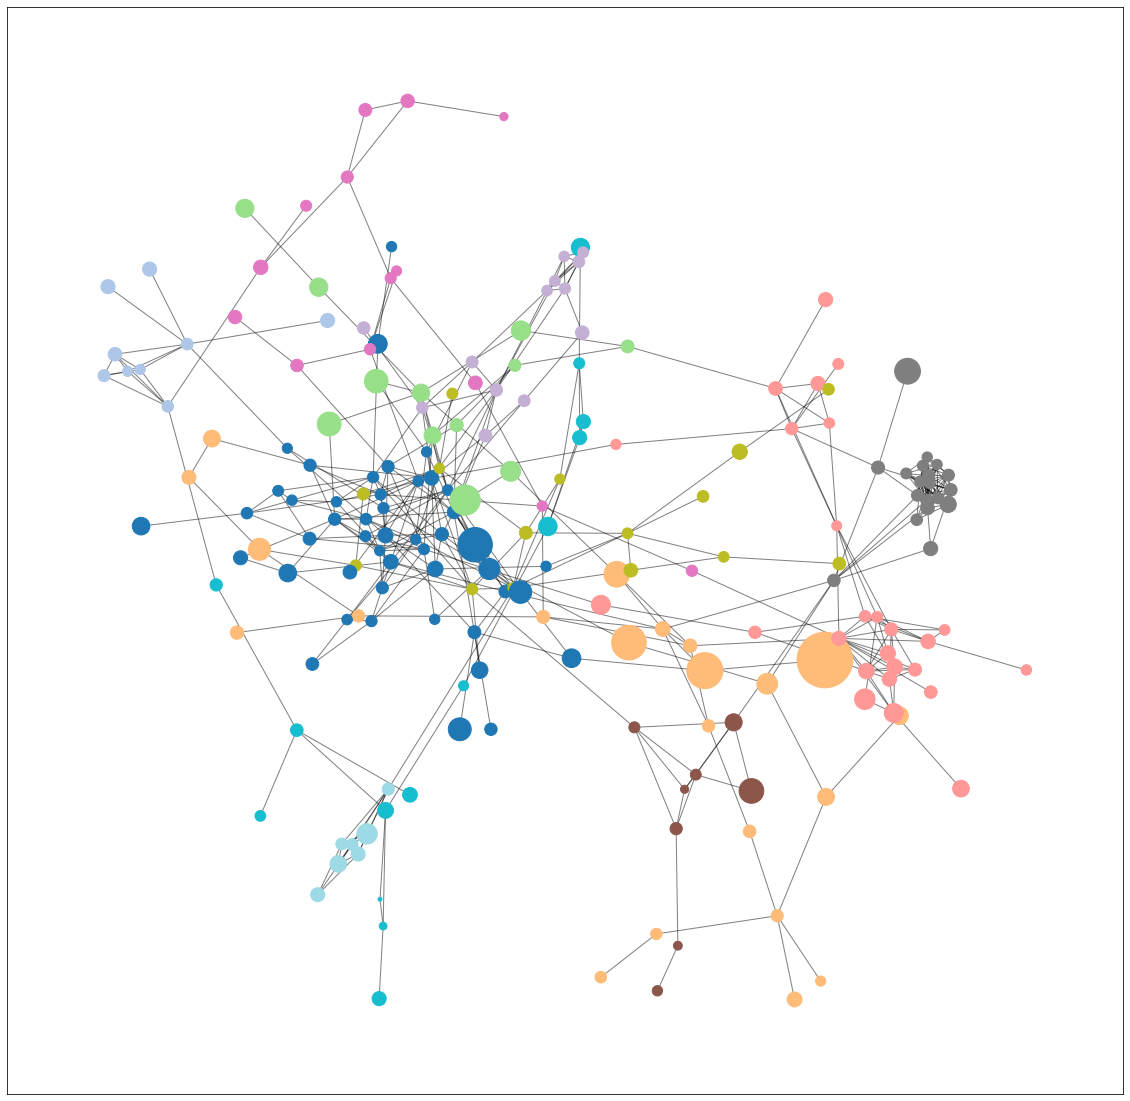

In [ ]:
largest_cc_G = G.subgraph(max(nx.connected_components(G), key=len)).copy()
plt.figure(figsize=(20,20))
# compute the best partition
partition = community_louvain.best_partition(largest_cc_G)
node_size = [d['count'] for (n,d) in largest_cc_G.nodes(data=True)]
# draw the graph
pos = nx.fruchterman_reingold_layout(largest_cc_G)
# color the nodes according to their partition
cmap = cm.get_cmap('tab20', max(partition.values()) + 1)

nx.draw_networkx_nodes(largest_cc_G, pos, partition.keys(), node_size=node_size,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(largest_cc_G, pos, alpha=0.5)
# nx.draw_networkx_labels(G, pos)
plt.show()

100%|██████████| 12/12 [00:00<00:00, 241.16it/s]


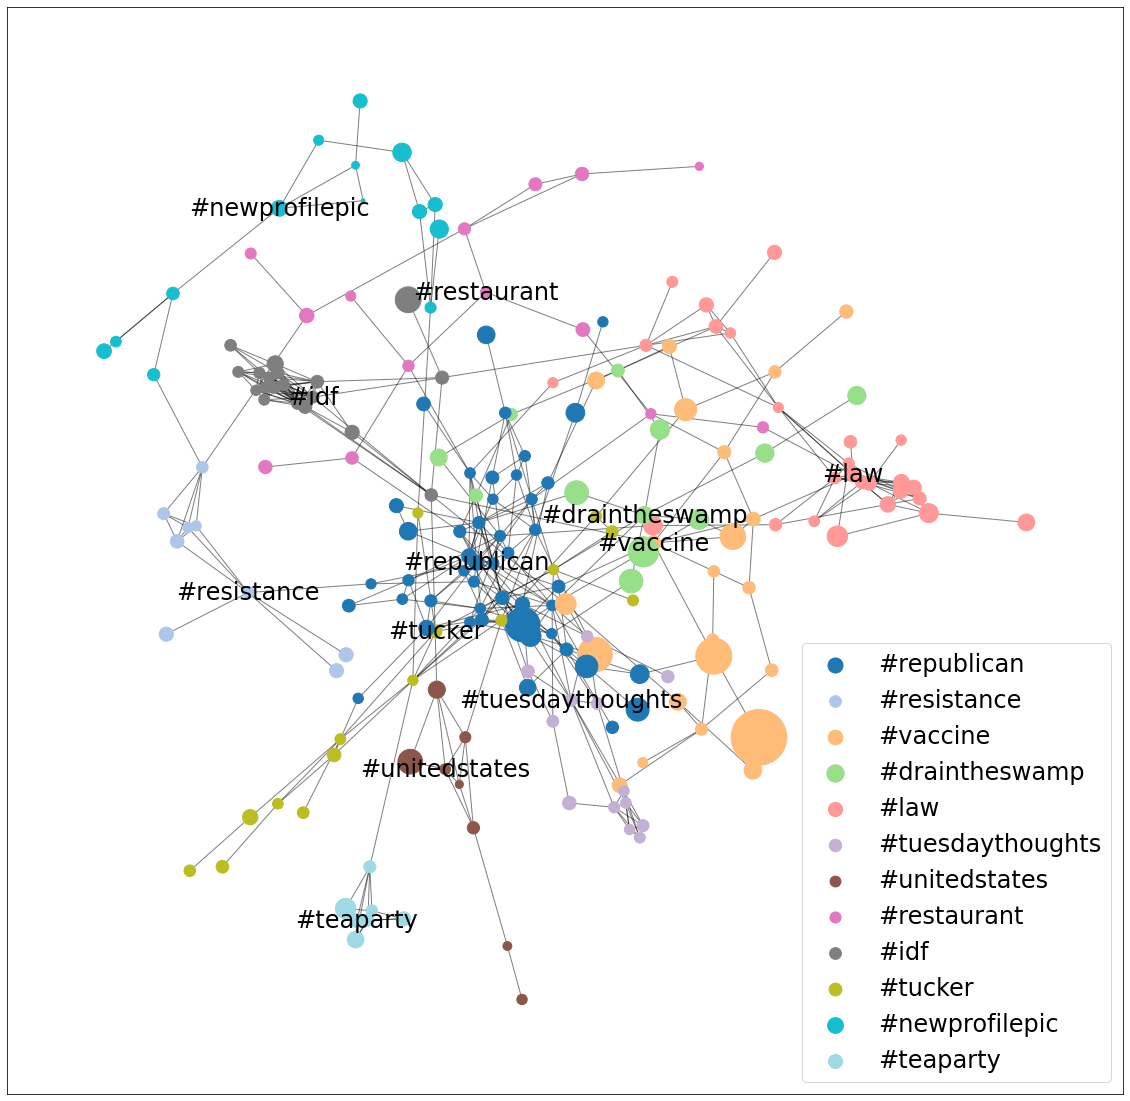

In [ ]:
communities = list(set(partition.values()))
comm2hashtags = {id: [] for id in communities}
for hashtag, id in partition.items():
  comm2hashtags[id].append(hashtag)

comm2closeness = {id: [] for id in communities}
for id, hashtags in tqdm(comm2hashtags.items(), total=len(comm2hashtags.items())):
  n = len(hashtags)
  for hashtag in hashtags:
    comm2closeness[id].append((hashtag, ((n-1)/(sum([nx.shortest_path_length(largest_cc_G, source=hashtag, target=other) for other in hashtags])))))

labels = {}
max_len_comm = 0
for id, closeness in comm2closeness.items():
  comm2closeness[id] = sorted(closeness, key=lambda x: x[1], reverse=True)
  hub = comm2closeness[id][0][0]
  labels[hub] = f"#{hub}"
  if max_len_comm < len(closeness): max_len_comm = len(closeness)

plt.figure(figsize=(20,20))
# compute the best partition
node_size = [d['count'] for (n,d) in largest_cc_G.nodes(data=True)]
# draw the graph
pos = nx.fruchterman_reingold_layout(largest_cc_G)
# color the nodes according to their partition
cmap = cm.get_cmap('tab20', max(partition.values()) + 1)
nx.draw_networkx_nodes(largest_cc_G, pos, partition.keys(), node_size=node_size,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(largest_cc_G, pos, alpha=0.5)
nx.draw_networkx_labels(largest_cc_G, pos, labels=labels, font_size=24)

comm_label_size = [largest_cc_G.nodes(data=True)[label]['count'] for label in labels.keys()]
for v in set(list(partition.values())):
    plt.scatter([],[], c=[cmap(v)], label=list(labels.values())[v], s=comm_label_size[v])


plt.legend(fontsize=24)
plt.show()

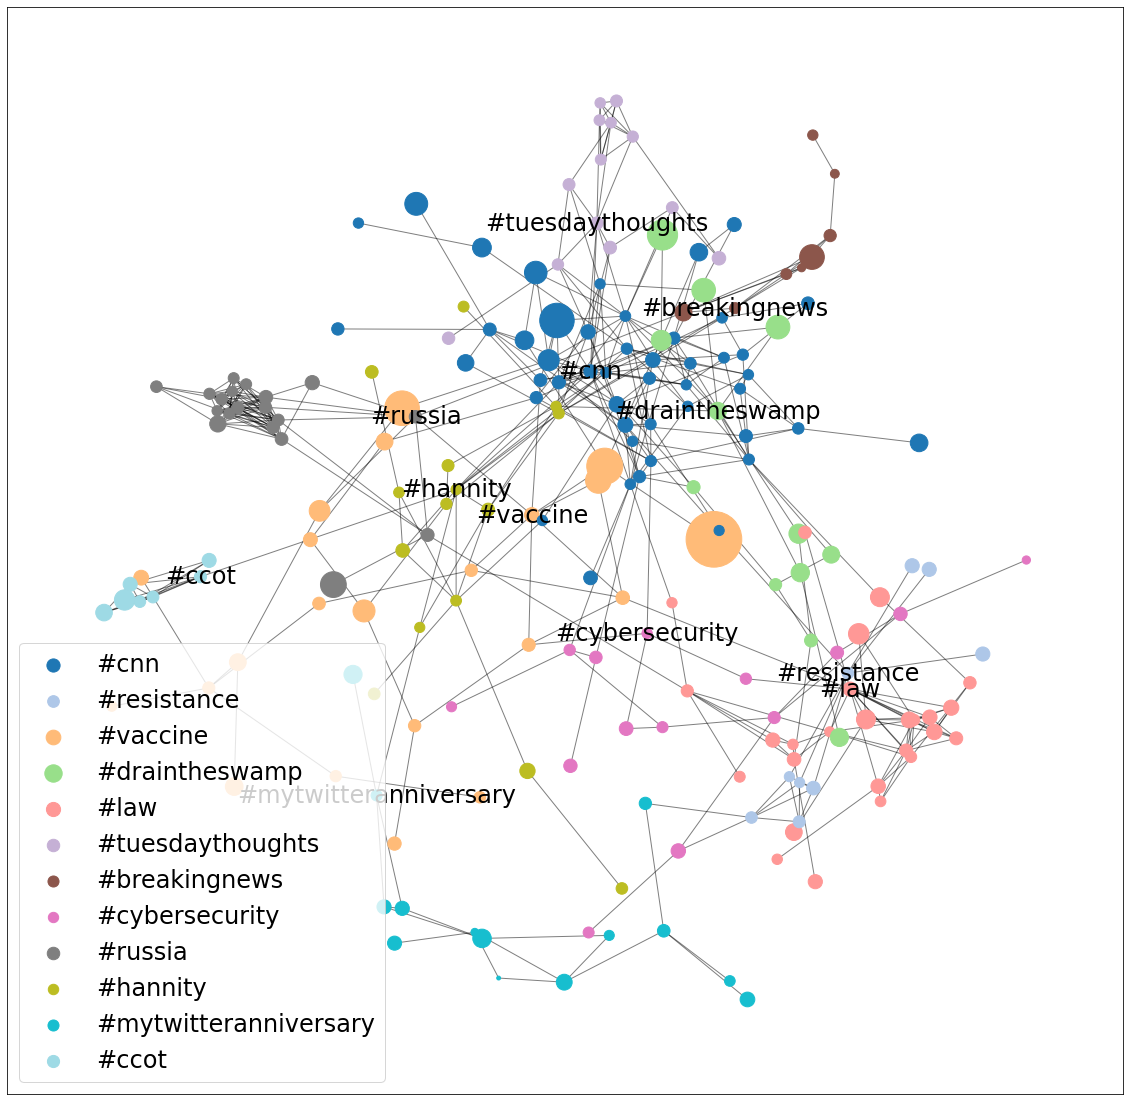

In [ ]:
communities = list(set(partition.values()))
comm2hashtags = {id: [] for id in communities}
for hashtag, id in partition.items():
  comm2hashtags[id].append(hashtag)

betw_central_list = sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)
betw_central_dict = {k: v for k, v in betw_central_list}
comm2betweenness = {}
for comm, hashtags in comm2closeness.items():
  comm2betweenness[comm] = []
  for hashtag, _ in hashtags:
    comm2betweenness[comm].append((hashtag, betw_central_dict[hashtag]))

labels = {}
max_len_comm = 0
for id, betweenness in comm2betweenness.items():
  comm2betweenness[id] = sorted(betweenness, key=lambda x: x[1], reverse=True)
  hub = comm2betweenness[id][0][0]
  labels[hub] = f"#{hub}"
  if max_len_comm < len(betweenness): max_len_comm = len(betweenness)

plt.figure(figsize=(20,20))
# compute the best partition
node_size = [d['count'] for (n,d) in largest_cc_G.nodes(data=True)]
# draw the graph
pos = nx.fruchterman_reingold_layout(largest_cc_G, k=0.1)
# color the nodes according to their partition
cmap = cm.get_cmap('tab20', max(partition.values()) + 1)
nx.draw_networkx_nodes(largest_cc_G, pos, partition.keys(), node_size=node_size,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(largest_cc_G, pos, alpha=0.5)
nx.draw_networkx_labels(largest_cc_G, pos, labels=labels, font_size=24)

comm_label_size = [largest_cc_G.nodes(data=True)[label]['count'] for label in labels.keys()]
for v in set(list(partition.values())):
    plt.scatter([],[], c=[cmap(v)], label=list(labels.values())[v], s=comm_label_size[v])


plt.legend(fontsize=24)
plt.show()

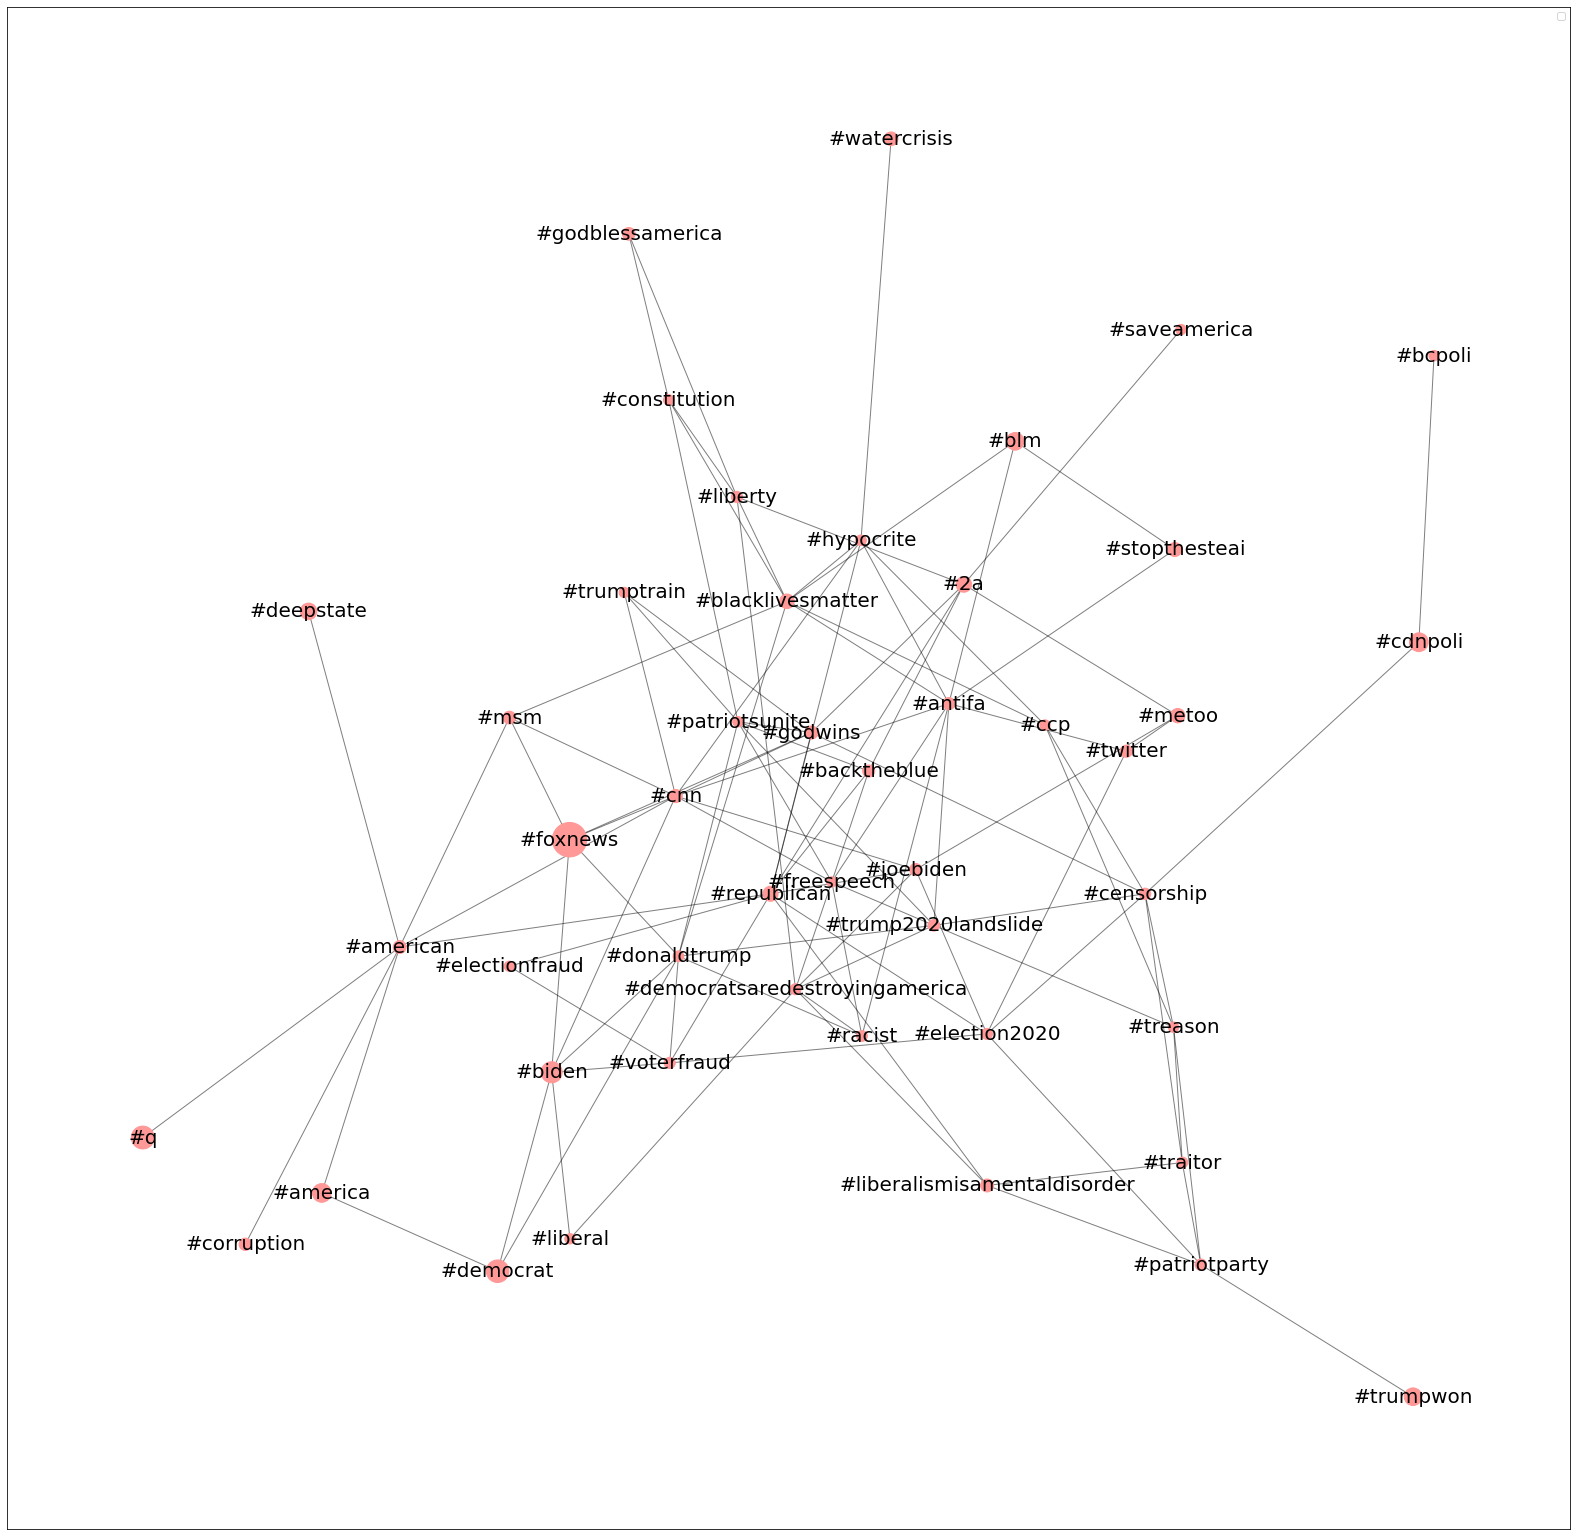

In [ ]:
largest_cc_comm = largest_cc_G.subgraph(comm2hashtags[0])
plt.figure(figsize=(28,28))

largest_cc_comm_partition = {}


largest_cc_comm_labels = {}
for hashtag in largest_cc_comm.nodes():
  largest_cc_comm_labels[hashtag] = f"#{hashtag}"
  largest_cc_comm_partition[hashtag] = partition[hashtag]

# compute the best partition
node_size = [d['count'] for (n,d) in largest_cc_comm.nodes(data=True)]
# draw the graph
pos = nx.fruchterman_reingold_layout(largest_cc_comm, k=0.2)
# color the nodes according to their partition

cmap = cm.get_cmap('tab20', max(partition.values()) + 1)

rgba = cmap(4)

nx.draw_networkx_nodes(largest_cc_comm, pos, largest_cc_comm_partition.keys(), node_size=node_size, 
                       cmap=cmap, node_color=rgba)
nx.draw_networkx_edges(largest_cc_comm, pos, alpha=0.5)
nx.draw_networkx_labels(largest_cc_comm, pos, labels=largest_cc_comm_labels, font_size=20)

plt.legend()
plt.show()

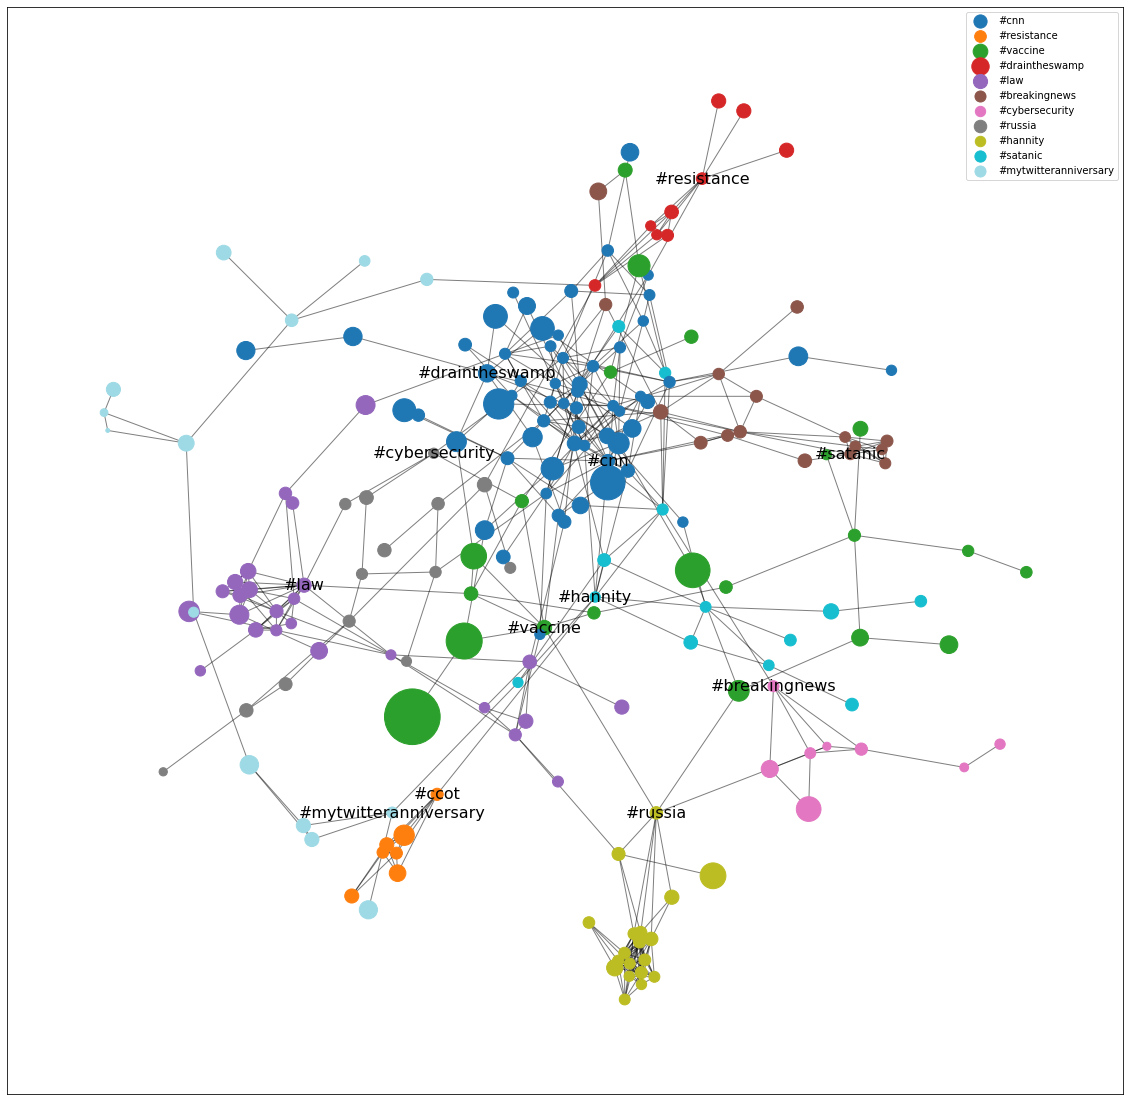

In [ ]:
betw_central_list = sorted(nx.betweenness_centrality(largest_cc_G).items(), key=lambda x: x[1], reverse=True)
betw_central_dict = {k: v for k, v in betw_central_list}
comm2betweenness = {}
for comm, hashtags in comm2closeness.items():
  comm2betweenness[comm] = []
  for hashtag, _ in hashtags:
    comm2betweenness[comm].append((hashtag, betw_central_dict[hashtag]))


betw_central_labels = {}
for id, betweenness in comm2betweenness.items():
  comm2betweenness[id] = sorted(betweenness, key=lambda x: x[1], reverse=True)
  hub = comm2betweenness[id][0][0]
  betw_central_labels[hub] = f"#{hub}"

plt.figure(figsize=(20,20))
# compute the best partition
partition = community_louvain.best_partition(largest_cc_G)
node_size = [d['count'] for (n,d) in largest_cc_G.nodes(data=True)]
# draw the graph
pos = nx.spring_layout(largest_cc_G)
# color the nodes according to their partition
cmap = cm.get_cmap('tab20', max(partition.values()) + 1)
nx.draw_networkx_nodes(largest_cc_G, pos, partition.keys(), node_size=node_size,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(largest_cc_G, pos, alpha=0.5)
nx.draw_networkx_labels(largest_cc_G, pos, labels=betw_central_labels, font_size=16)

comm_label_size = [largest_cc_G.nodes(data=True)[label]['count'] for label in betw_central_labels.keys()]
for v in set(list(partition.values())):
    plt.scatter([],[], c=[cmap(v)], label=list(betw_central_labels.values())[v], s=comm_label_size[v])


plt.legend()
plt.show()

No handles with labels found to put in legend.


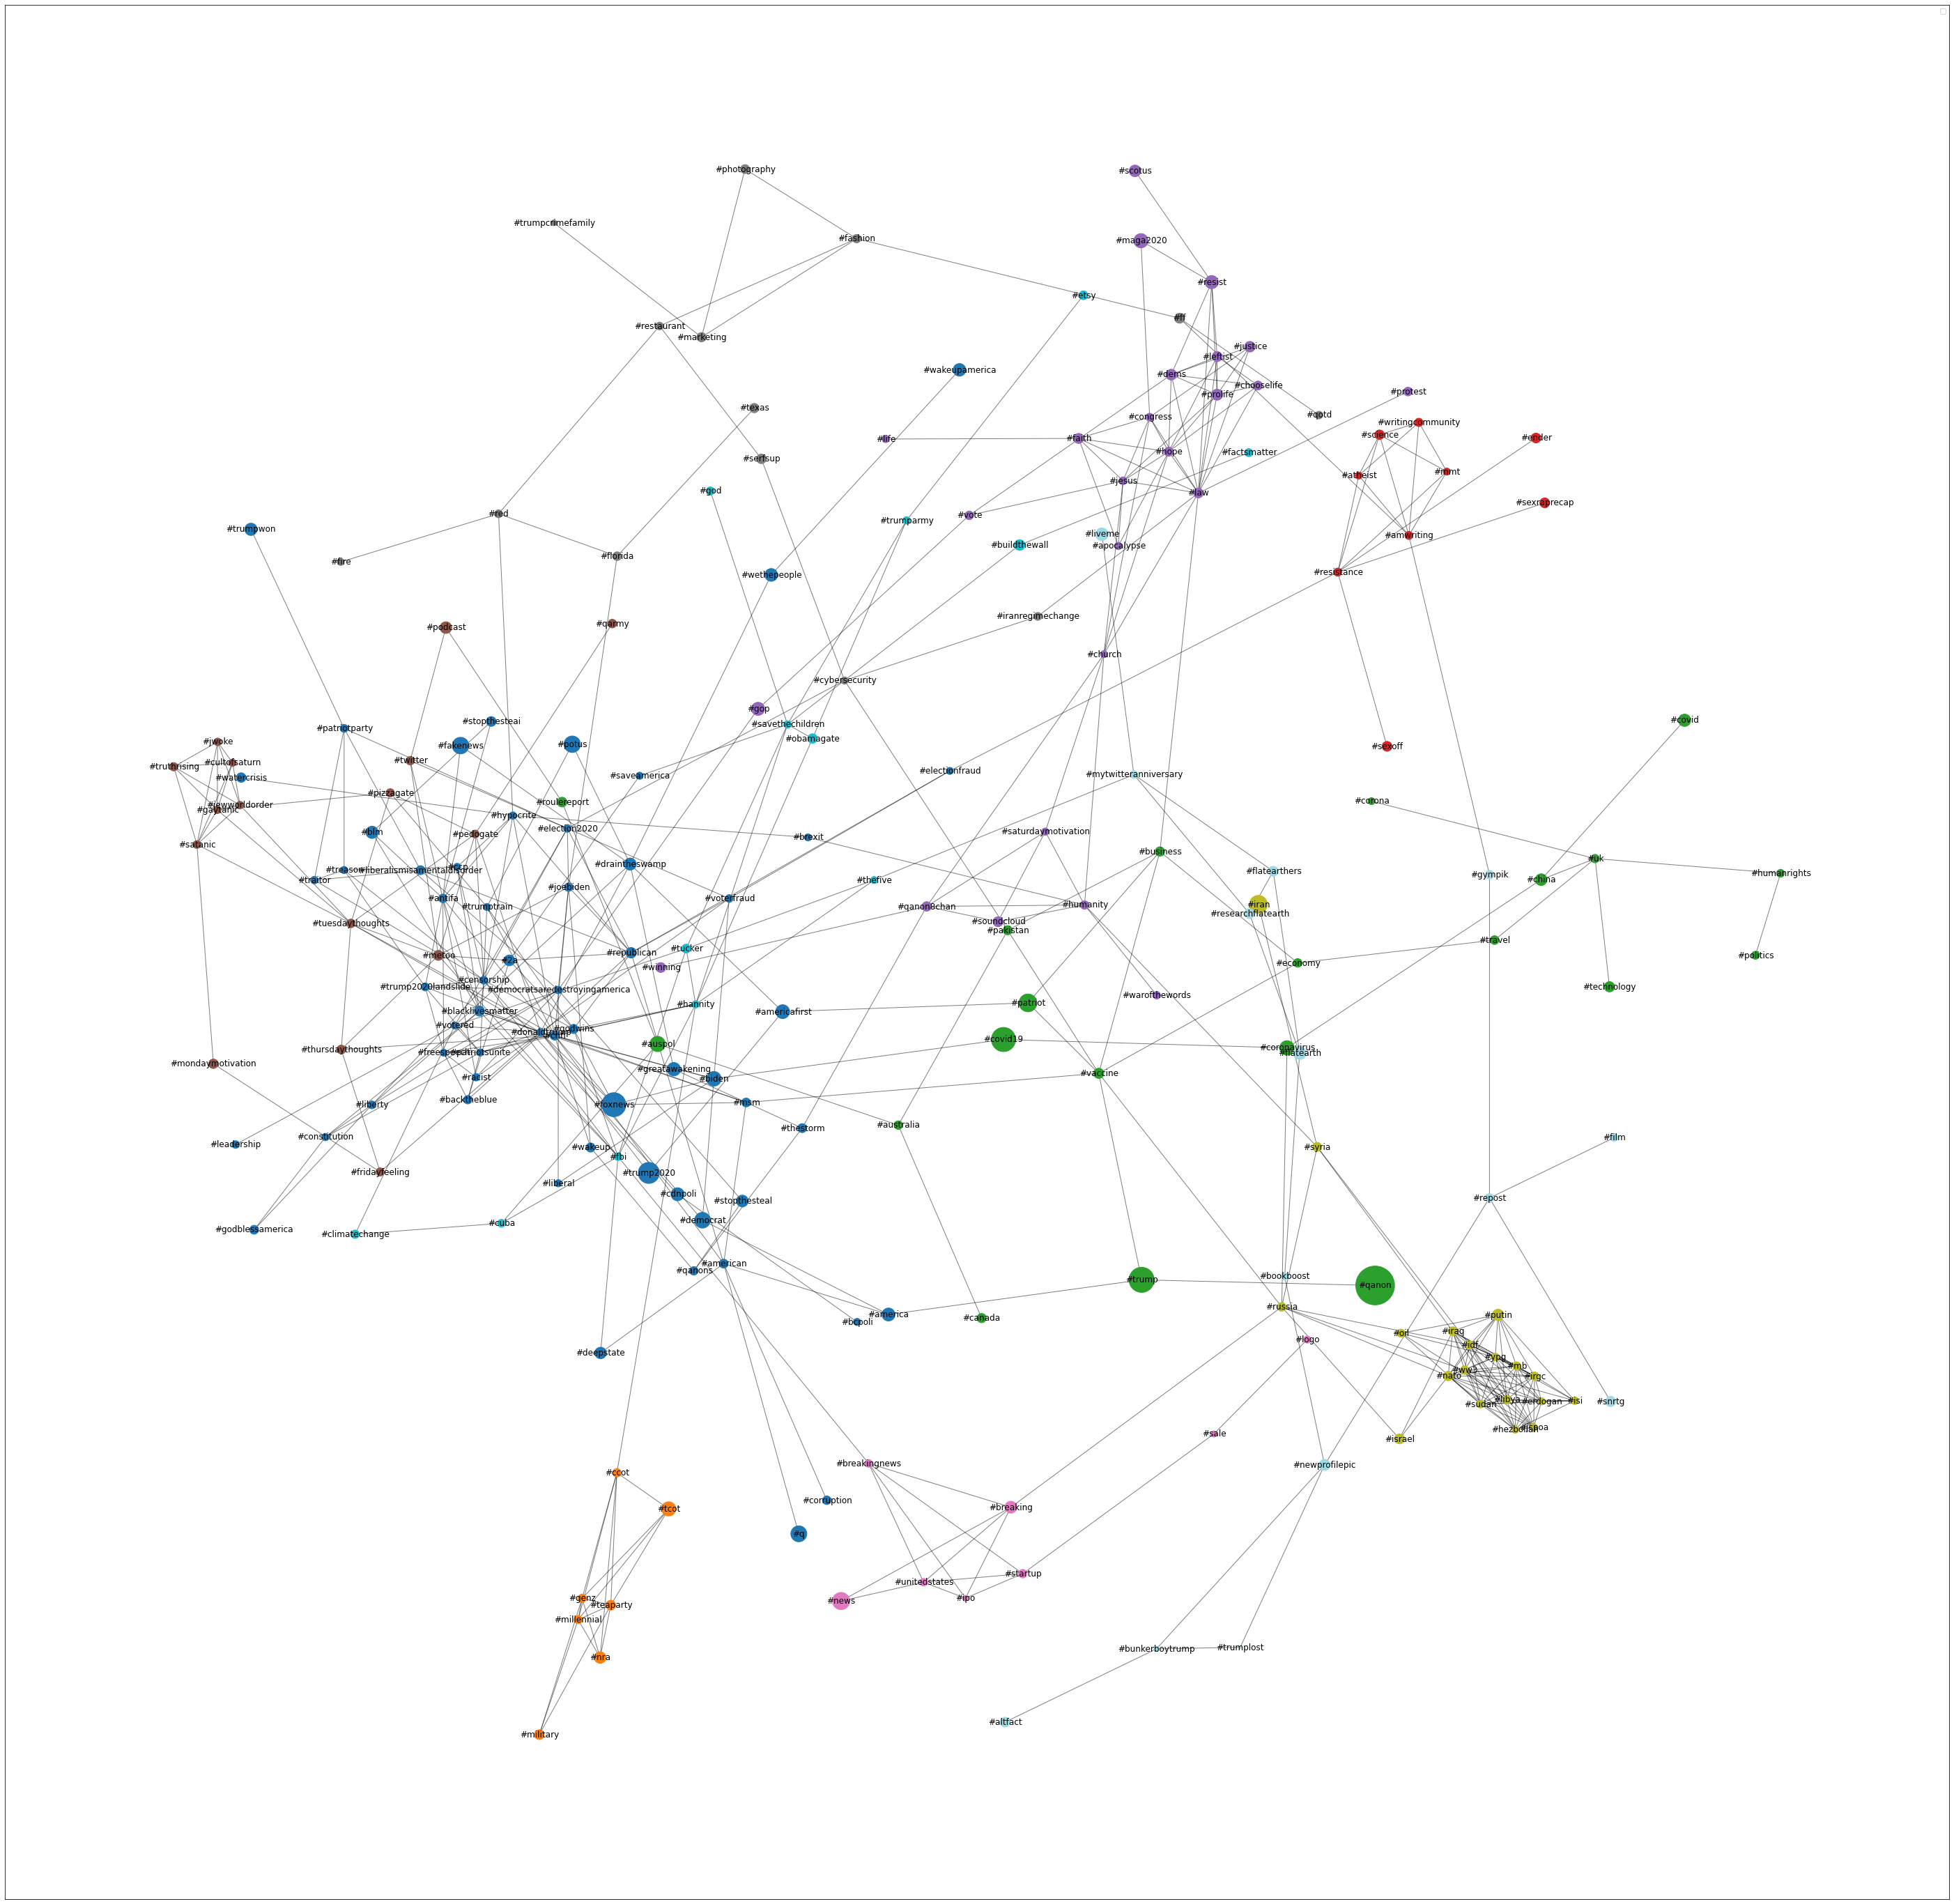

In [ ]:
all_labels = {}
for id, betweenness in comm2betweenness.items():
  for hashtag, _ in comm2betweenness[id]:
      all_labels[hashtag] = f"#{hashtag}"

plt.figure(figsize=(50,50))
# compute the best partition
node_size = [d['count'] for (n,d) in largest_cc_G.nodes(data=True)]
# draw the graph
pos = nx.spring_layout(largest_cc_G, k=0.1)
# color the nodes according to their partition
cmap = cm.get_cmap('tab20', max(partition.values()) + 1)
nx.draw_networkx_nodes(largest_cc_G, pos, partition.keys(), node_size=node_size,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(largest_cc_G, pos, alpha=0.5)
nx.draw_networkx_labels(largest_cc_G, pos, labels=all_labels)


plt.legend()
plt.show()

In [ ]:
comm2closeness_copy = comm2closeness.copy()
for id, closeness in comm2closeness_copy.items():
  while len(closeness) < max_len_comm:
    comm2closeness_copy[id].append(('', 0))
  comm2hashtags[id] = [hashtag for hashtag, closeness in comm2closeness_copy[id]]

hashtag_community_df = pd.DataFrame(comm2hashtags)
# hashtag_community_df.to_csv(FOLDER_PATH+"/semantic network/hashtags_community.csv", header=False, index=False)
hashtag_community_df

0                 1            2   \
0                             cnn        resistance      vaccine   
1                     donaldtrump           science      economy   
2                      republican               mmt     business   
3                blacklivesmatter           atheist       travel   
4                         godwins  writingcommunity  coronavirus   
5              trump2020landslide         amwriting     pakistan   
6                          antifa       sexraprecap           uk   
7                      censorship            sexoff        china   
8                       hypocrite             ender        trump   
9                      freespeech                        patriot   
10                       joebiden                      australia   
11                   election2020                    humanrights   
12                             2a                        covid19   
13                     voterfraud                         corona   
14                  patriotsunite                     technology   
15                tuesdaythoughts                          covid   
16                       pedogate                          qanon   
17                          biden                         auspol   
18                        foxnews                         canada   
19                       american                       politics   
20                          metoo                    roulereport   
21  democratsaredestroyingamerica                                  
22                         racist                                  
23                     trumptrain                                  
24                    backtheblue                                  
25                        liberty                                  
26                        twitter                                  
27                            ccp                                  
28                            msm                                  
29    liberalismisamentaldisorder                                  
30               thursdaythoughts                                  
31                        treason                                  
32                   constitution                                  
33                  fridayfeeling                                  
34                       democrat                                  
35                            blm                                  
36                  electionfraud                                  
37                        traitor                                  
38                        liberal                                  
39                   patriotparty                                  
40                      deepstate                                  
41                      pizzagate                                  
42                   stopthesteai                                  
43                        america                                  
44                        cdnpoli                                  
45                    watercrisis                                  
46                    saveamerica                                  
47                          qarmy                                  
48                     corruption                                  
49                              q                                  
50                godblessamerica                                  
51                        podcast                                  
52               mondaymotivation                                  
53                       trumpwon                                  
54                         bcpoli                                  

                3                   4             5                 6   \
0    draintheswamp                 law  unitedstates        restaurant   
1   greatawakening              church       startup           fashion   


100%|██████████| 105747/105747 [00:07<00:00, 14476.02it/s]



9899 tweets here
[(4, {'counts': 501, 'keywords': ['daily', 'latest', 'thanks', 'project', 'coach', 'politics', 'united', 'vets', 'carson', 'shochat']}), (6, {'counts': 233, 'keywords': ['latest', 'thanks', 'sense', 'common', 'millenial', 'loft', 'consulting', 'hedges', 'godsword', 'aussie']}), (14, {'counts': 155, 'keywords': ['amp', 'guitar', 'teleprompter', 'to', 'of', 'the', 'it', 'our', 'their', 'gretsch']}), (106, {'counts': 86, 'keywords': ['coffee', 'mug', 'oz', 'cup', 'gift', 'tea', 'anon', 'coincidence', 'awakening', 'ceramic']}), (2, {'counts': 83, 'keywords': ['biden', 'joe', 'bidens', 'president', 'cheating', 'harris', 'cheat', 'he', 'trump', 'unity']}), (10, {'counts': 77, 'keywords': ['twitter', 'tweet', 'retweet', 'unavailable', 'temporarily', 'violates', 'tweets', 'policy', 'account', 'retweeted']}), (145, {'counts': 75, 'keywords': ['rt', 'water', 'pakistan', 'pir', 'lake', 'roof', 'drought', 'roofing', 'pakistani', 'flint']}), (3, {'counts': 69, 'keywords': ['god', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


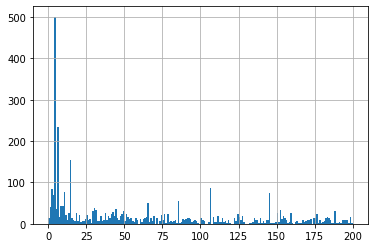

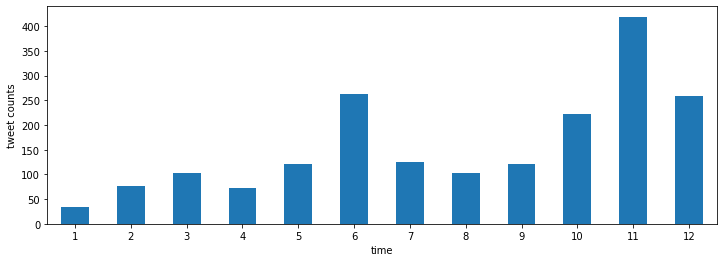

In [ ]:
comm_tweets_df_0 = get_related_tweets(0, hashtag_community_df)

In [ ]:
def get_related_tweets(community_id, hashtag_community_df):
  comm_tweet_id_list = []
  for id, hashtags in tqdm(id2hashtags_filtered.items(), total=len(id2hashtags_filtered.items())):
    if bool(set(hashtags) & set(hashtag_community_df.iloc[:, community_id].values)):
      comm_tweet_id_list.append(id)
  print()
  print(f"{len(comm_tweet_id_list)} tweets here")
  comm_tweet_df = all_tweets_df[all_tweets_df['id'].isin(comm_tweet_id_list)]
  comm_tweet_df[comm_tweet_df['cleaned_text'].str.len() > 0]['topic'].hist(bins=200, range=(0, 200))
  topic_counts = sorted(Counter(comm_tweet_df[comm_tweet_df['cleaned_text'].str.len() > 0]['topic']).items(), key=lambda x: x[1], reverse=True)[1:]
  topicId2keywords = {}
  for topic_id, counts in topic_counts:
    topicId2keywords[topic_id] = {'counts': counts, 'keywords': topic_df[topic_df['topic_id'] == topic_id].keyword.tolist()[0]}
  print(sorted(topicId2keywords.items(), key=lambda x: x[1]['counts'], reverse=True)[:10])
  comm_tweet_df.index = pd.to_datetime(comm_tweet_df['time'], infer_datetime_format=True)
  
  comm_tweet_df_copy = comm_tweet_df.copy()
  comm_tweet_df_copy['dummy'] = [1]*len(comm_tweet_df_copy)

  fig, axs = plt.subplots(figsize=(12, 4))
  comm_tweet_df_copy.loc['2020-01-01':'2020-12-31'].groupby(comm_tweet_df_copy.loc['2020-01-01':'2020-12-31'].index.month)['dummy'].sum().plot(kind = 'bar', rot=0, ax=axs)

  plt.xlabel("time")
  plt.ylabel("tweet counts")
  return comm_tweet_df

100%|██████████| 105747/105747 [00:06<00:00, 15964.21it/s]


[(145, {'counts': 0.10344827586206896, 'keywords': ['rt', 'water', 'pakistan', 'pir', 'lake', 'roof', 'drought', 'roofing', 'pakistani', 'flint']}), (4, {'counts': 0.09328635014836795, 'keywords': ['daily', 'latest', 'thanks', 'project', 'coach', 'politics', 'united', 'vets', 'carson', 'shochat']}), (106, {'counts': 0.07257383966244725, 'keywords': ['coffee', 'mug', 'oz', 'cup', 'gift', 'tea', 'anon', 'coincidence', 'awakening', 'ceramic']}), (6, {'counts': 0.054625755462575545, 'keywords': ['latest', 'thanks', 'sense', 'common', 'millenial', 'loft', 'consulting', 'hedges', 'godsword', 'aussie']}), (14, {'counts': 0.050433665274654677, 'keywords': ['amp', 'guitar', 'teleprompter', 'to', 'of', 'the', 'it', 'our', 'their', 'gretsch']})]


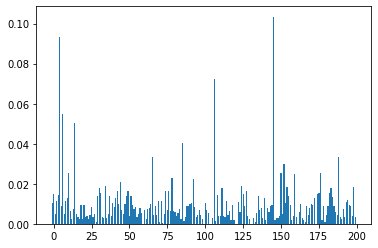

In [ ]:
community_id = 0
tweets_w_hashtags_df = all_tweets_df[(all_tweets_df['raw_cleaned_text'] != '')]
comm_tweet_id_list = []
for id, hashtags in tqdm(id2hashtags_filtered.items(), total=len(id2hashtags_filtered.items())):
  if bool(set(hashtags) & set(hashtag_community_df.iloc[:, community_id].values)):
    comm_tweet_id_list.append(id)
comm_tweets_df =  all_tweets_df[(all_tweets_df['id'].isin(comm_tweet_id_list)) & (all_tweets_df['raw_cleaned_text'] != '')]
topicId2counts = Counter(tweets_w_hashtags_df['topic'].values)
comm_topicId2counts = Counter(comm_tweets_df['topic'].values)
comm_topic_freq_dict = {}
for topicId, counts in topicId2counts.items():
  try:
    comm_counts = comm_topicId2counts[topicId]
  except:
    comm_counts = 0
  comm_topic_freq_dict[topicId] = comm_counts / counts

plt.bar(comm_topic_freq_dict.keys(), comm_topic_freq_dict.values())

topic_counts = sorted(comm_topic_freq_dict.items(), key=lambda x: x[0], reverse=True)
topicId2keywords = {}
for topic_id, counts in topic_counts:
  topicId2keywords[topic_id] = {'counts': counts, 'keywords': topic_df[topic_df['topic_id'] == topic_id].keyword.tolist()[0]}

print(sorted(topicId2keywords.items(), key=lambda x: x[1]['counts'], reverse=True)[:5])